# Imports

In [1]:
from itertools import combinations
from typing import List, Optional, Union

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial
import seaborn as sns
from matplotlib.axes import Axes
from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from statannotations.Annotator import Annotator
from umap import UMAP

sns.set_style("white")

# Helper functions definition

In [2]:
def agify(s):
    if int(s) <= 20:
        return "<=20"
    elif 20 < int(s) <= 60:
        return "20-60"
    else:
        return ">60"

In [3]:
def sort_by_terms_order(
    data: pd.Series, t_order: list, vector: pd.Series = None
) -> np.ndarray:
    """
    Sort "data" into blocks with values from "t_order". If "vector" is provided, sort each block by corresponding
    values in "vector"
    :param data: pd.Series
    :param t_order: list, values for blocks to sort "data" into
    :param vector: pd.Series, same index as data, which values to sort each block by
    :return: np.array, 1 dimensional
    """

    x = []

    for term in t_order:
        indices = data[data == term].index

        if len(indices):
            if vector is not None:
                x.append(vector.reindex(indices).dropna().sort_values().index)
            else:
                x.append(indices)

    return np.concatenate(x)

In [4]:
def get_stacked_axes(ys, title="", x_len=8, title_y=1, sharex=True):
    """
    Return an axis iterative for subplots stacked vertically
    :param ys: list, list of lengths by 'y'
    :param title: str, title for plot
    :param x_len: int, length by 'x'
    :param sharex: boolean, images will be shared if True
    :param title_y: absolute y position for suptitle
    :return: axs.flat, numpy.flatiter object which consists of axes (for further plots)
    """
    fig, axs = plt.subplots(
        len(ys),
        1,
        figsize=(x_len, np.sum(ys)),
        gridspec_kw={"height_ratios": ys},
        sharex=sharex,
    )
    fig.suptitle(title, y=title_y)

    for ax in axs:
        ax.tick_params(axis="x", which="minor", length=0)

    return axs.flat


def line_annotation_plot(
    color_vector: np.ndarray,
    ax=None,
    nan_color="#ffffff",
    offset=0,
    hide_ticks=True,
    hide_borders=True,
) -> Axes:
    """
    Plot a horizontal line annotation with colored bars.

    Parameters
    ----------
    :param color_vector: A 1D array of colors to use for the bars.
    :param ax: The axes to plot on. If not provided, a new figure and axes will be created.
    :param nan_color:  The color to use for NaN values in `color_vector`.
    :param offset:  The offset to apply to the x-coordinates of the bars.
    :param hide_ticks:  Whether to hide the ticks on the x and y axes.
    :param hide_borders: Whether to hide the borders of the plot.

    :return: The axes object containing the plot.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(max(len(color_vector) / 15.0, 6), 0.5))

    items_amount = len(color_vector)

    xss = np.arange(items_amount) - offset
    yss = pd.Series([1] * items_amount, index=color_vector.index)

    with sns.axes_style("white"):
        ax.bar(
            xss,
            yss,
            color=color_vector.fillna(nan_color),
            width=1,
            align="edge",
            edgecolor=color_vector.fillna(nan_color),
        )

    ax.set_ylim(0, 1)
    ax.set_xlim(0, items_amount)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(color_vector.name, rotation=0, labelpad=10, va="center", ha="right")

    if hide_ticks:
        ax.tick_params(length=0)

    if hide_borders:
        for spine in ["bottom", "top", "left", "right"]:
            ax.spines[spine].set_visible(False)

    return ax


def line_palette_annotation_plot(
    val_vector,
    palette: dict[str, str],
    ax=None,
    nan_color="#ffffff",
    hide_ticks=True,
    hide_borders=True,
    **kwargs,
):
    """
    Draws line annotation plot
    :param val_vector: pd.Series with values
    :param palette: dict, palette for values
    :param ax: ax to plot
    :param nan_color: str, color for np.nan
    :param hide_ticks: bool, whether to plot ticks
    :param hide_borders: bool, whether to plot borders
    :return: ax with plot
    """
    return line_annotation_plot(
        val_vector.map(palette),
        ax=ax,
        nan_color=nan_color,
        hide_ticks=hide_ticks,
        hide_borders=hide_borders,
        **kwargs,
    )


def palette_plot(
    patches: dict[str, str],
    ax: Optional[Axes] = None,
    order: Union[str, List[str]] = "sort",
    w: float = 0.25,
    h: float = 0,
    vertical: bool = False,
    legend_right: bool = True,
    show_ticks: bool = False,
) -> Axes:
    """
    Plots given palette (dict key:color) as a pretty legend
    :param patches: dict with keys - labels, and values - colors
    :param ax: ax to plot
    :param order: list with order of labels
    :param w: int, width
    :param h: int, 0 - auto determine
    :param vertical: bool, whether to make vertical plot instead of horizontal
    :param legend_right: bool, whether to plot legend on the right
    :param show_ticks: book, whether to show ticks on plot
    :return:
    """

    if order == "sort":
        order = sorted(patches.keys())
    else:
        order = [key for key in order if key in patches]

    bar_positions = np.arange(len(order))
    bar_heights = [1] * len(order)
    bar_colors = [patches[key] for key in order]

    if ax is None:
        if h == 0:
            h = 0.3 * len(patches)
        if vertical:
            _, ax = plt.subplots(figsize=(h, w))
        else:
            _, ax = plt.subplots(figsize=(w, h))

    if vertical:
        ax.bar(bar_positions, bar_heights, color=bar_colors, align="center")
        ax.set_yticks([])
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(order)
    else:
        ax.barh(bar_positions, bar_heights, color=bar_colors, align="center")
        ax.set_xticks([])
        ax.set_yticks(bar_positions)
        ax.set_yticklabels(order)
        if legend_right:
            ax.yaxis.tick_right()

    sns.despine(offset={"left": -2}, ax=ax)
    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    if not show_ticks:
        ax.tick_params(length=0)

    return ax

In [5]:
def contingency_bar_plot(
    data,
    palette=None,
    lrot=0,
    figsize=(5, 5),
    title="",
    ax=None,
    order=None,
    stars=False,
    percent=False,
    pvalue=False,
    p_digits=5,
    legend=True,
    xl=True,
    offset=-0.1,
    linewidth=0,
    align="center",
    bar_width=0.9,
    edgecolor=None,
    hide_grid=True,
    draw_horizontal=False,
    plot_all_borders=True,
    **kwargs
):
    """
    Plot a stacked bar plot based on contingency table

    Parameters
    ----------
    data: pd.DataFrame
        contingency table for plotting. Each element of index corresponds to a bar.
    palette: dict
        palette for plotting. Keys are unique values from groups, entries are color hexes
    lrot: float
        rotation angle of bar labels in degrees
    figsize: (float, float)
        figure size in inches
    title: str
        plot title
    ax: matplotlib axis
        axis to plot on
    order: list
        what order to plot the stacks of each bar in. Contains column labels of "data"
    stars: bool
        whether to use the star notation for p value instead of numerical value
    percent: bool
        whether to normalize each bar to 1
    pvalue: bool
        whether to add the p value (chi2 contingency test) to the plot title.
    p_digits: int
        number of digits to round the p value to
    legend: bool
        whether to plot the legend
    xl: bool
        whether to plot bar labels (on x axis for horizontal plot, on y axis for vertical plot)
    hide_grid: bool
        whether to hide grid on plot
    draw_horizontal: bool
        whether to draw horizontal bot bar plot
    plot_all_borders: bool
        whether to plot top and right border

    Returns
    -------
    matplotlib axis
    """
    from matplotlib.ticker import FuncFormatter

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    if pvalue:
        from scipy.stats import chi2_contingency

        chi2_test_data = chi2_contingency(data)
        p = chi2_test_data[1]
        if title is not False:
            title += "\n" + get_pvalue_string(p, p_digits, stars=stars)

    if percent:
        c_data = data.apply(lambda x: x * 1.0 / x.sum(), axis=1)
        if title:
            title = "% " + title
        ax.set_ylim(0, 1)
    else:
        c_data = data

    c_data.columns = [str(x) for x in c_data.columns]

    if order is None:
        order = c_data.columns
    else:
        order = [str(x) for x in order]

    if palette is None:
        c_palette = lin_colors(pd.Series(order))

        if len(order) == 1:
            c_palette = {order[0]: blue_color}
    else:
        c_palette = {str(k): v for k, v in palette.items()}

    if edgecolor is not None:
        edgecolor = [edgecolor] * len(c_data)

    kind_type = "bar"
    if draw_horizontal:
        kind_type = "barh"

    c_data[order].plot(
        kind=kind_type,
        stacked=True,
        position=offset,
        width=bar_width,
        color=pd.Series(order).map(c_palette).values,
        ax=ax,
        linewidth=linewidth,
        align=align,
        edgecolor=edgecolor,
    )

    ax = contingency_bar_plot_prettify_axis(
        ax,
        c_data,
        legend,
        draw_horizontal,
        xl,
        lrot,
        title,
        hide_grid,
        plot_all_borders,
        **kwargs
    )

    if percent:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))

    return ax


def contingency_bar_plot_prettify_axis(
    ax,
    c_data,
    legend,
    draw_horizontal,
    xl,
    lrot,
    title,
    hide_grid,
    plot_all_borders,
    **kwargs
):
    """
    Change some properties of contingency_bar_plot ax

    Returns
    -------
    prettified axis
    """

    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
    else:
        ax.legend_.remove()

    if "ylabel" in kwargs.keys():
        ax.set(ylabel=kwargs["ylabel"])

    if "xlabel" in kwargs.keys():
        ax.set(xlabel=kwargs["xlabel"])

    if not draw_horizontal:
        ax.set_xticks(np.arange(len(c_data.index)) + 0.5)
        if xl:
            ax.set_xticklabels(c_data.index, rotation=lrot)
        else:
            ax.set_xticklabels([])
    else:
        ax.set_yticks(np.arange(len(c_data.index)) + 0.5)
        if xl:
            ax.set_yticklabels(c_data.index, rotation=lrot)
        else:
            ax.set_yticklabels([])

    if title is not False:
        ax.set_title(title)

    if hide_grid:
        ax.grid(False)

    sns.despine(ax=ax)

    if plot_all_borders:
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)

    return ax

# Loading dataset

In [6]:
cell_typing = anndata.read_h5ad("../data/NBM_dataset.h5ad")

case_id_age_mapping = {
    k: v for k, v in cell_typing.obs[["case_id", "age_at_dx"]].drop_duplicates().values
}

case_id_age_group_mapping = {
    k: v for k, v in cell_typing.obs[["case_id", "age_group"]].drop_duplicates().values
}

In [7]:
clinical_annotation = pd.read_csv("../data/clinical_annotation.csv")

In [8]:
case_id_tissue_area_mapping = {
    k: v for k, v in clinical_annotation[["case_id", "tissue"]].values
}

case_cell_density = cell_typing.obs.groupby(["case_id", "cell_type"], as_index=False)[
    "cell_index"
].count()

case_cell_density["tissue_area"] = (
    case_cell_density["case_id"].map(case_id_tissue_area_mapping).astype(np.float32)
)
case_cell_density["cell_density"] = (
    case_cell_density["cell_index"] / case_cell_density["tissue_area"]
)

## Visualize

In [9]:
cell_type_palette = cell_typing.uns["cell_type_palette"]
cell_type_order = cell_typing.uns["cell_type_order"]
tissue_type_palette = cell_typing.uns["tissue_type_palette"]
age_group_palette = cell_typing.uns["age_group_palette"]
gender_palette = cell_typing.uns["gender_palette"]
graph_cluster_palette = cell_typing.uns["graph_cluster_palette"]
staging_palette = cell_typing.uns["staging_palette"]
cytopenia_palette = cell_typing.uns["cytopenia_palette"]

sample_order = cell_typing.uns["sample_order"]
cluster_order = [f"cluster_{i}" for i in range(6)]

### Check cd34 signal distribution for HSPC and Endothelium

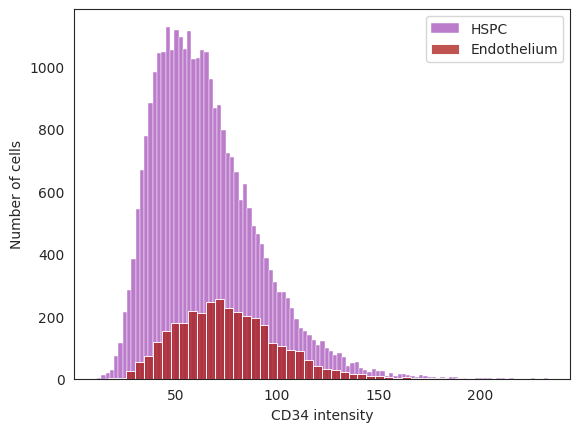

In [10]:
cd34_signal_distribution = (
    cell_typing[cell_typing.obs["cell_type"].isin(["HSPC", "Endothelium"]), :]
    .obs[["cell_type", "CD34_mean_intensity"]]
    .set_index("cell_type")
)

for cell_type in ["HSPC", "Endothelium"]:
    sns.histplot(
        cd34_signal_distribution.loc[cell_type, "CD34_mean_intensity"],
        color=cell_type_palette[cell_type],
    )
    plt.legend(["HSPC", "Endothelium"])
    plt.ylabel("Number of cells")
    plt.xlabel("CD34 intensity")

### Visualize difference between Likely B-cell precursors and Plasma cells

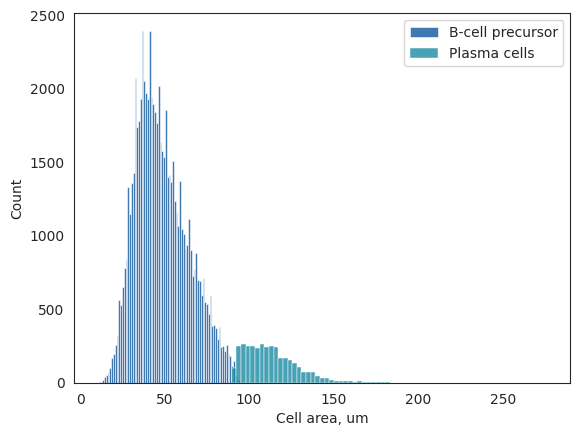

In [11]:
cell_size_distribution = (
    cell_typing[
        cell_typing.obs["cell_type"].isin(["B-cell precursor", "Plasma cells"]), :
    ]
    .obs[["cell_type", "cell_area_um"]]
    .set_index("cell_type")
)

for cell_type in ["B-cell precursor", "Plasma cells"]:
    sns.histplot(
        cell_size_distribution.loc[cell_type, "cell_area_um"],
        color=cell_type_palette[cell_type],
    )
    plt.legend(["B-cell precursor", "Plasma cells"])
    plt.xlabel("Cell area, um")

### Visualize clusters differences for some cell types

In [12]:
cluster_diff = cell_typing.obs.groupby(["case_id", "chm", "cell_type"], as_index=False)[
    "cell_area_um"
].mean()
cluster_diff = cluster_diff[cluster_diff["cell_area_um"].notna()]
cluster_diff = cluster_diff[cluster_diff["cell_area_um"] <= 400]
cluster_diff = cell_typing.obs.groupby(
    ["age_group", "case_id", "graph_cluster"], as_index=False
)["cell_type"].value_counts(normalize=True)
cluster_diff = cluster_diff[cluster_diff["proportion"] != 0]
cluster_diff = cluster_diff.reset_index(drop=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cluster_1 vs. cluster_5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.237e-01 U_stat=3.210e+02


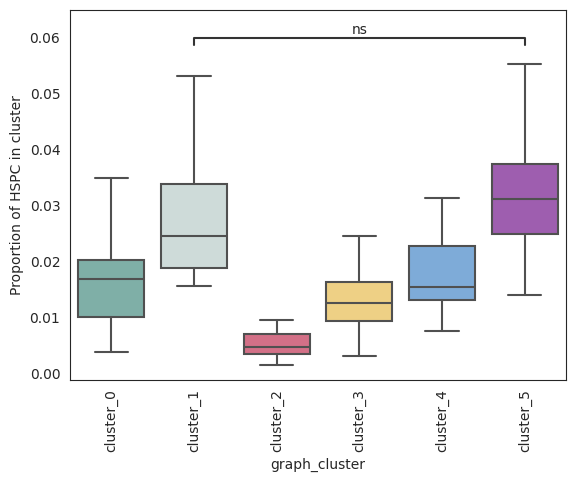

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cluster_1 vs. cluster_5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.092e-03 U_stat=2.100e+02


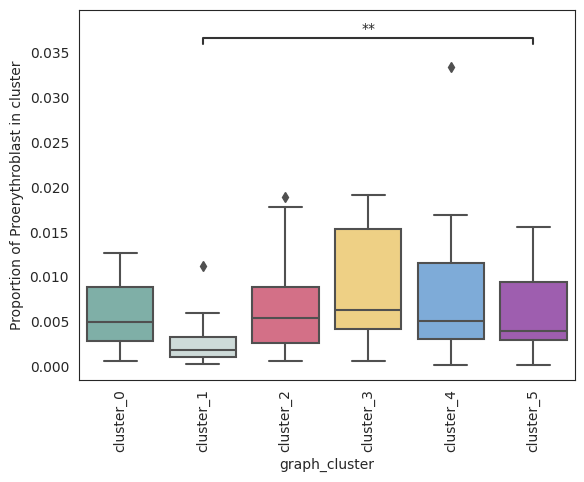

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cluster_1 vs. cluster_5: Mann-Whitney-Wilcoxon test two-sided, P_val:2.911e-03 U_stat=2.190e+02


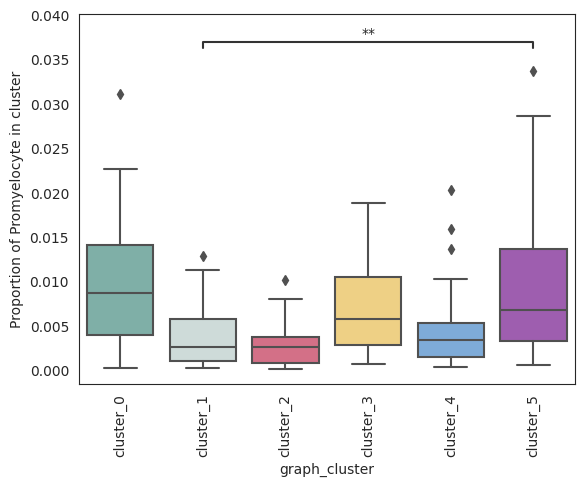

In [13]:
comparison_pairs = [("cluster_5", f"cluster_1")]

for studied_cell_type in ["HSPC", "Proerythroblast", "Promyelocyte"]:
    ax = sns.boxplot(
        data=cluster_diff[cluster_diff["cell_type"] == studied_cell_type],
        x="graph_cluster",
        y="proportion",
        palette=graph_cluster_palette,
    )
    plt.ylabel(f"Proportion of {studied_cell_type} in cluster")
    ax.tick_params(axis="x", labelrotation=90)

    annotator = Annotator(
        ax,
        comparison_pairs,
        data=cluster_diff[cluster_diff["cell_type"] == studied_cell_type],
        x="graph_cluster",
        y="proportion",
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")

    annotator.apply_and_annotate()

    plt.show()
    plt.close()

# Analysis

In [14]:
graph_cluster_cell_counts = pd.pivot_table(
    cell_typing.obs,
    index="graph_cluster",
    columns="cell_type",
    values="cell_index",
    aggfunc=len,
)

graph_cluster_cell_percentage = graph_cluster_cell_counts.div(
    graph_cluster_cell_counts.sum(axis=1), axis=0
)

In [15]:
patient_cell_counts = pd.pivot_table(
    cell_typing.obs,
    index="case_id",
    columns="cell_type",
    values="cell_index",
    aggfunc=len,
)

patient_cell_counts = patient_cell_counts.div(patient_cell_counts.sum(axis=1), axis=0)

In [16]:
graph_cluster_cell_per_clust_percentage = graph_cluster_cell_counts.div(
    graph_cluster_cell_counts.sum(axis=0), axis=1
)

### Investigate differences in tissue composition in clusters

In [17]:
graph_cluster_mask_distro = cell_typing.obs.groupby(["graph_cluster"])[
    [
        "nb_num_pixels_150_Endothelium",
        "nb_num_pixels_150_Fat",
        "nb_num_pixels_150_Trabeculae",
    ]
].mean()

graph_cluster_mask_scaled = graph_cluster_mask_distro.apply(zscore)

In [18]:
graph_cluster_features = pd.concat(
    [graph_cluster_cell_percentage, graph_cluster_mask_scaled], axis=1
)

In [19]:
for i in graph_cluster_features.filter(like="nb_").columns:
    graph_cluster_features[i.split("_")[-1]] = graph_cluster_features[i]

In [20]:
row_linkage = hierarchy.linkage(distance.pdist(graph_cluster_features), method="ward")
cluster_order = hierarchy.leaves_list(row_linkage)

cluster_order = graph_cluster_features.iloc[cluster_order, :].index.to_list()

In [21]:
tissue_bar = pd.melt(
    graph_cluster_features.loc[
        cluster_order,
        graph_cluster_features.filter(like="nb_").columns.map(
            lambda x: x.split("_")[-1]
        ),
    ],
    ignore_index=False,
    var_name="Tissue",
    value_name="z-score",
)

Text(0, 0.5, 'Cluster')

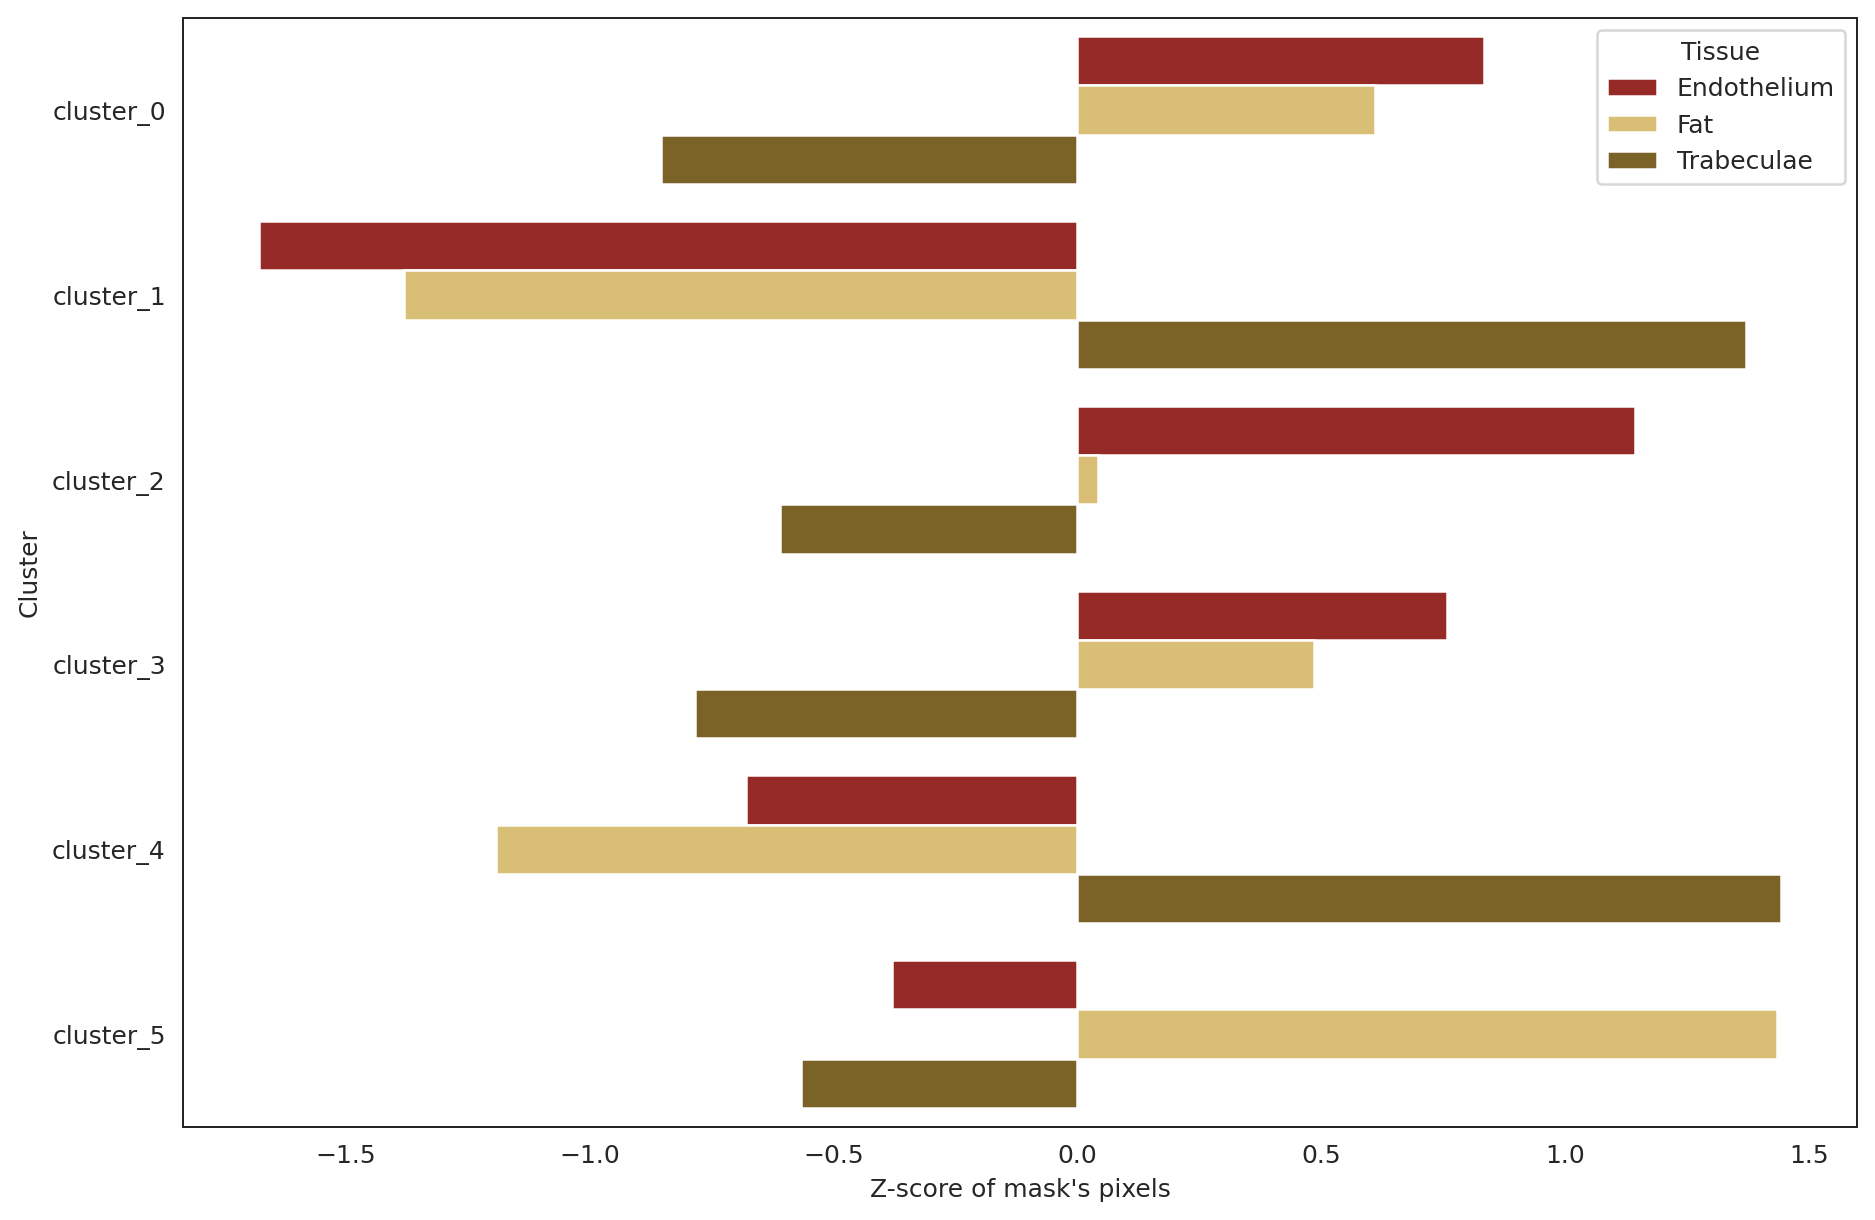

In [22]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=180)

sns.barplot(
    data=tissue_bar.reset_index(),
    y="graph_cluster",
    x="z-score",
    hue="Tissue",
    ax=ax,
    palette=tissue_type_palette,
    orient="h",
)

ax.tick_params(axis="x", labelrotation=0)
ax.tick_params(axis="y", labelrotation=0)
ax.set_xlabel("Z-score of mask's pixels")
ax.set_ylabel("Cluster")

### Visualize normalized cluster cell type composition

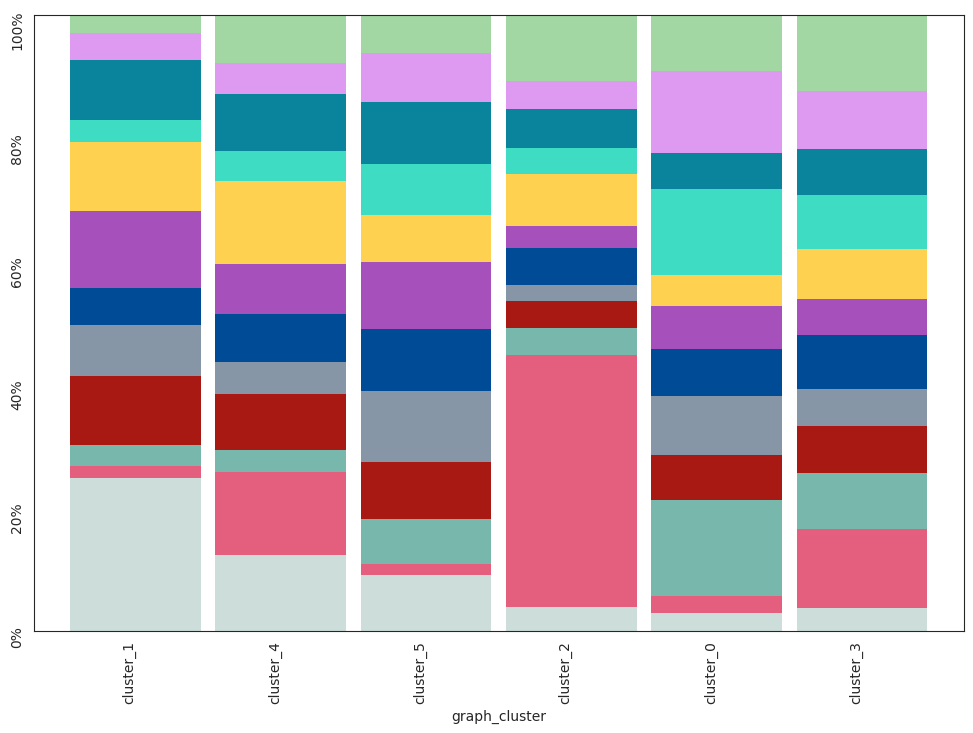

In [23]:
ax = contingency_bar_plot(
    graph_cluster_cell_per_clust_percentage.loc[
        cluster_order, cell_typing.obs["cell_type"].unique()
    ],
    palette=cell_type_palette,
    percent=True,
    figsize=(12, 8),
    legend=False,
    draw_horizontal=False,
)

ax.tick_params(axis="y", labelrotation=90)
ax.tick_params(axis="x", labelrotation=90)

### Visualize unnormalized cluster cell type composition

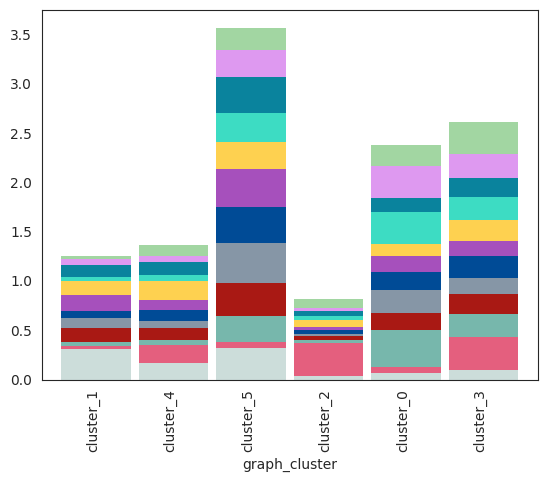

In [25]:
fig, ax = plt.subplots()

contingency_bar_plot(
    graph_cluster_cell_per_clust_percentage.loc[
        cluster_order, cell_typing.obs["cell_type"].unique()
    ],
    palette=cell_type_palette,
    percent=False,
    ax=ax,
    legend=False,
)

ax.tick_params(axis="x", labelrotation=90)
ax.tick_params(axis="y", labelrotation=0)

### Visualize relative cluster cell type composition

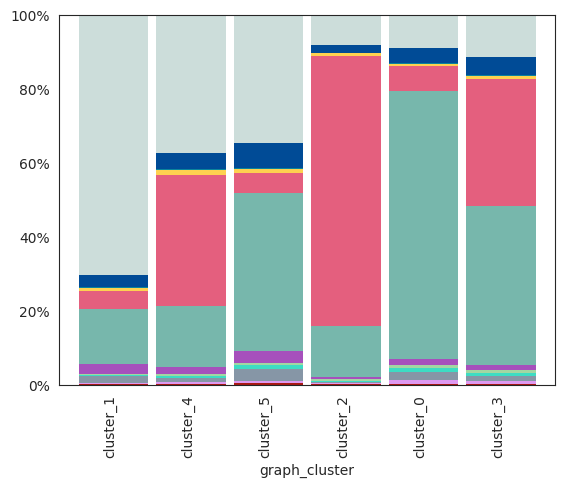

In [26]:
fig, ax = plt.subplots()

contingency_bar_plot(
    graph_cluster_cell_percentage.loc[cluster_order, cell_type_order],
    palette=cell_type_palette,
    percent=True,
    ax=ax,
    legend=False,
)

ax.tick_params(axis="x", labelrotation=90)
ax.tick_params(axis="y", labelrotation=0)

# Community graph embedding UMAP plot

In [27]:
sampled_clusters = cell_typing.obs["graph_cluster"].sample(500000)

In [30]:
cell_typing.X

array([[ 0.08543729, -0.15736279, -0.42845565, ...,  0.02112979,
         0.57116306,  0.6120772 ],
       [ 0.03373848, -0.2589024 , -0.4186867 , ...,  0.09575901,
         0.5700572 ,  0.6005584 ],
       [-0.02040839, -0.20772845, -0.33206674, ...,  0.07035008,
         0.2994597 ,  0.3605774 ],
       ...,
       [-0.00788493, -0.14132874, -0.21972817, ...,  0.0443423 ,
         0.093382  ,  0.19460878],
       [-0.17032063, -0.00718196, -0.04927187, ...,  0.07491665,
        -0.15573092, -0.0035716 ],
       [-0.04809738,  0.09233572, -0.07439622, ..., -0.01906918,
        -0.12793516,  0.02872824]], dtype=float32)

In [35]:
sampled_X = cell_typing.X[sampled_clusters.index.astype(int).values, :]

In [36]:
model = UMAP(n_components=2, random_state=42, verbose=True, n_jobs=4)
embedding = model.fit_transform(sampled_X)

/home/asarachakov/python10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value 4 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=4, random_state=42, verbose=True)
Fri Jan 19 12:05:22 2024 Construct fuzzy simplicial set
Fri Jan 19 12:05:24 2024 Finding Nearest Neighbors
Fri Jan 19 12:05:24 2024 Building RP forest with 40 trees
Fri Jan 19 12:05:36 2024 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Fri Jan 19 12:06:09 2024 Finished Nearest Neighbor Search
Fri Jan 19 12:06:23 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jan 19 12:16:14 2024 Finished embedding


<Axes: >

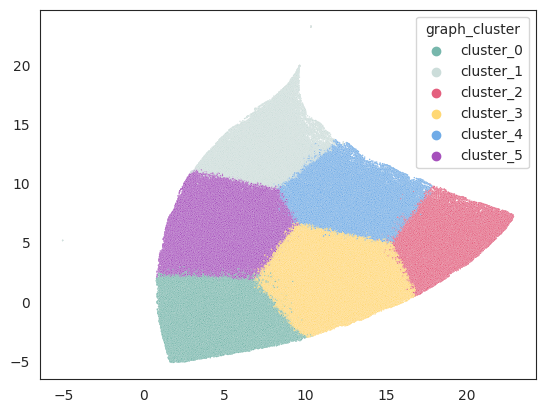

In [37]:
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=sampled_clusters,
    s=1,
    palette=graph_cluster_palette,
)

### Prepare datasets for later

In [38]:
community_cell_counts = pd.pivot_table(
    cell_typing.obs,
    index=["sample_id", "case_id"],
    columns="graph_cluster",
    values="cell_index",
    aggfunc=len,
)

community_cell_percentages = community_cell_counts.div(
    community_cell_counts.sum(axis=1), axis=0
)
community_cell_percentages = community_cell_percentages.reset_index(drop=False)

community_cell_percentages = community_cell_percentages.set_index("sample_id").loc[
    sample_order
]

community_cell_percentages = community_cell_percentages.set_index("case_id")

In [39]:
community_cell_fraction = pd.pivot_table(
    cell_typing.obs,
    index=["sample_id", "case_id"],
    columns="cell_type",
    values="cell_index",
    aggfunc=len,
)

community_cell_fraction = community_cell_fraction.div(
    community_cell_fraction.sum(axis=1), axis=0
)
community_cell_fraction = community_cell_fraction.reset_index(drop=False)

community_cell_fraction = community_cell_fraction.set_index("sample_id").loc[
    sample_order
]

community_cell_fraction = community_cell_fraction.set_index("case_id")

In [40]:
community_with_age = community_cell_percentages.copy()
community_with_age["age_at_dx"] = community_with_age.index.to_series().map(
    case_id_age_mapping
)
community_with_age["age_group"] = community_with_age.index.to_series().map(
    case_id_age_group_mapping
)

In [41]:
community_cell_fraction["Plasma_to_B"] = (
    community_cell_fraction["Plasma cells"]
    / community_cell_fraction["B-cell precursor"]
)

### Visualize amount of Plasma and Likely B-cells in samples

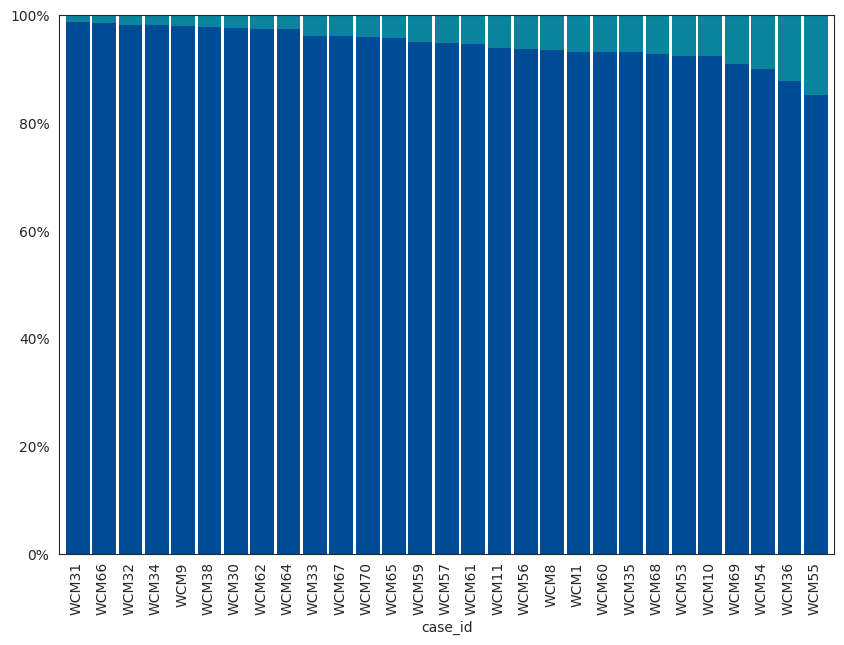

In [42]:
plot_sample_order = community_cell_fraction.sort_values(by="Plasma_to_B").index.astype(
    str
)

ax = contingency_bar_plot(
    community_cell_fraction.loc[
        plot_sample_order, ["B-cell precursor", "Plasma cells"]
    ],
    palette=cell_type_palette,
    percent=True,
    legend=False,
)

plt.gcf().set_size_inches((10, 7))

ax.tick_params(axis="x", labelrotation=90, size=2)

In [43]:
community_cell_fraction = community_cell_fraction.drop(columns=["Plasma_to_B"])

### Visualize cell and community proportions

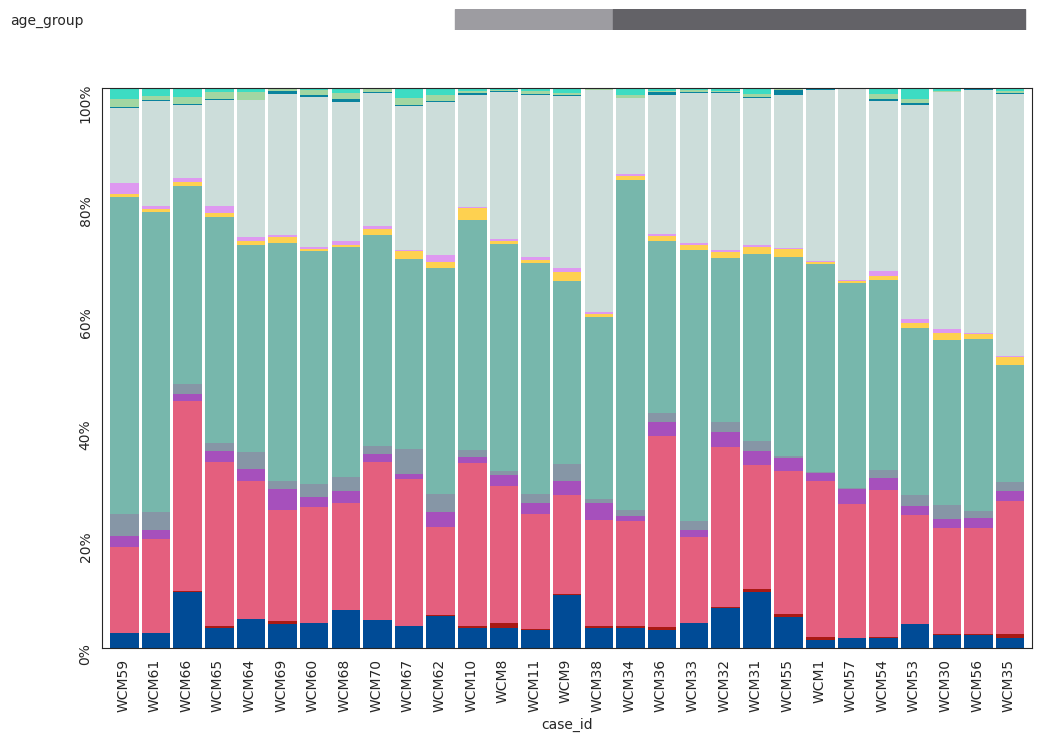

In [44]:
plot_sample_order = sort_by_terms_order(
    data=community_with_age["age_group"],
    vector=community_with_age["cluster_1"],
    t_order=["<=20", "20-60", ">60"],
)


af = get_stacked_axes(ys=[0.3, 8], x_len=12)

line_palette_annotation_plot(
    val_vector=community_with_age["age_group"][plot_sample_order],
    palette=age_group_palette,
    ax=next(af),
)

ax = contingency_bar_plot(
    community_cell_fraction.loc[plot_sample_order, :],
    palette=cell_type_palette,
    percent=True,
    legend=False,
    ax=next(af),
)

ax.tick_params(axis="x", labelrotation=90)
ax.tick_params(axis="y", labelrotation=90)

<Axes: >

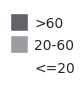

In [46]:
palette_plot(age_group_palette, order=["<=20", "20-60", ">60"])

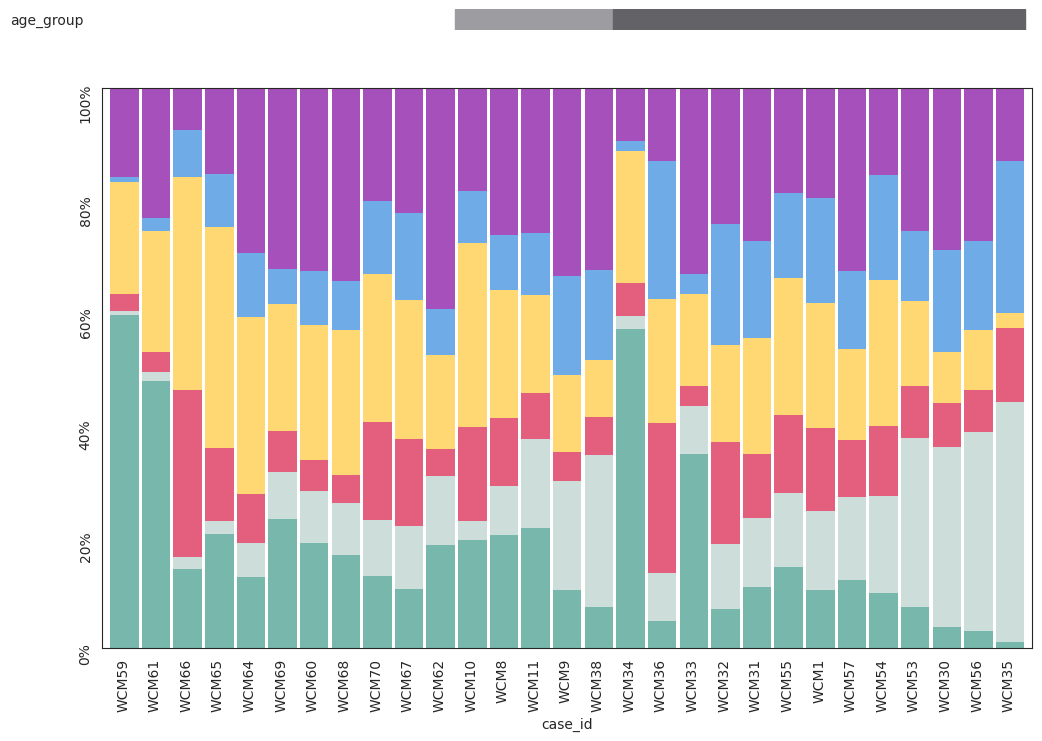

In [47]:
af = get_stacked_axes(ys=[0.3, 8], x_len=12)

line_palette_annotation_plot(
    val_vector=community_with_age["age_group"][plot_sample_order],
    palette=age_group_palette,
    ax=next(af),
)

ax = contingency_bar_plot(
    community_cell_percentages.loc[plot_sample_order, :],
    palette=graph_cluster_palette,
    percent=True,
    legend=False,
    ax=next(af),
)

ax.tick_params(axis="x", labelrotation=90)
ax.tick_params(axis="y", labelrotation=90)

# Clinical annotations

In [48]:
cell_density = dict()

for cell_type, cell_type_data in case_cell_density.groupby("cell_type"):
    cell_type_result = {
        "Median per case": cell_type_data["cell_index"].median(numeric_only=True),
        "Total": cell_type_data["cell_index"].sum(),
        "Density per mkm": cell_type_data["cell_density"].mean().round(5),
    }

    print(
        f'{cell_type} {cell_type_result["Median per case"]}/case, total={cell_type_result["Total"]}, density={cell_type_result["Density per mkm"]} cells/mkm'
    )

    cell_density[cell_type] = cell_type_result

B-cell precursor 1979.0/case, total=71396, density=7e-05 cells/mkm
Endothelium 72.0/case, total=3372, density=0.0 cells/mkm
Erythroid Normoblasts 11248.0/case, total=339276, density=0.00036 cells/mkm
HSPC 1041.0/case, total=30463, density=3e-05 cells/mkm
Mast cells 789.0/case, total=29532, density=3e-05 cells/mkm
Maturing myeloid cells 16500.0/case, total=597387, density=0.00062 cells/mkm
Megakaryocyte 372.0/case, total=12739, density=1e-05 cells/mkm
Myeloblasts 190.0/case, total=9102, density=1e-05 cells/mkm
Non-hematopoietic elements 12682.0/case, total=392506, density=0.00044 cells/mkm
Plasma cells 86.0/case, total=3520, density=0.0 cells/mkm
Proerythroblast 199.0/case, total=10074, density=1e-05 cells/mkm
Promyelocyte 246.0/case, total=10928, density=1e-05 cells/mkm


### Distribution of nuclei ratio in Non-hematopoietic elements per cluster

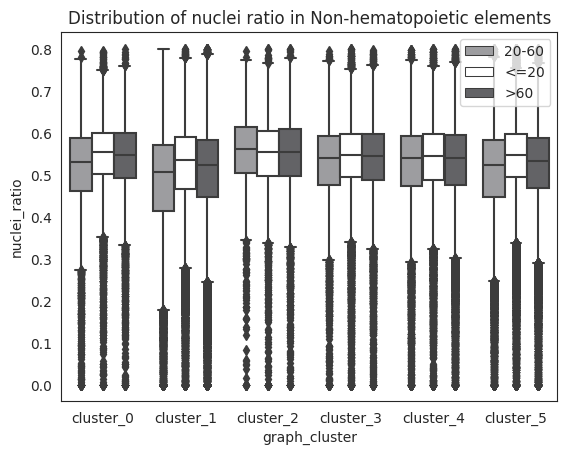

In [49]:
nuclei_data = cell_typing.obs[
    cell_typing.obs["cell_type"] == "Non-hematopoietic elements"
][["graph_cluster", "age_group", "nuclei_ratio"]]

nuclei_data = nuclei_data[
    nuclei_data["nuclei_ratio"] <= nuclei_data["nuclei_ratio"].quantile(0.999)
]
sns.boxplot(
    data=nuclei_data,
    x="graph_cluster",
    y="nuclei_ratio",
    hue="age_group",
    palette=age_group_palette,
)

plt.title(f"Distribution of nuclei ratio in Non-hematopoietic elements")
plt.legend(loc=1)

### Check community fraction per age group

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test smaller, P_val:4.487e-02 U_stat=1.200e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:3.875e-01 U_stat=2.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:1.565e-03 U_stat=2.000e+01
graph_cluster cluster_1                                                    \
                  count      mean       std       min       25%       50%   
age_group                                                                   
20-60               5.0  0.148990  0.092678  0.033547  0.086706  0.158633   
<=20               11.0  0.066810  0.042767  0.006721  0.022115  0.084245   
>60                13.0  0.187152  0.122929  0.022724  0.115973  0.141302   

graph_cluster                      
                    75%       max  
age_group                          
20-60          0.194749  0.271316  
<=20           0.096174  0.124442  
>60            0.301884  0.429844  


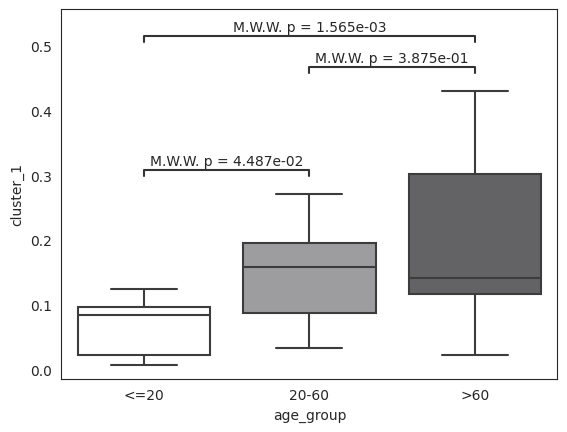

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test smaller, P_val:3.434e-02 U_stat=1.100e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:1.038e-01 U_stat=1.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:2.710e-03 U_stat=2.300e+01
graph_cluster cluster_4                                                    \
                  count      mean       std       min       25%       50%   
age_group                                                                   
20-60               5.0  0.127324  0.038111  0.092396  0.097850  0.110226   
<=20               11.0  0.085027  0.042938  0.008418  0.071202  0.086565   
>60                13.0  0.161035  0.072339  0.018071  0.138509  0.173014   

graph_cluster                      
                    75%       max  
age_group                          
20-60          0.160744  0.175406  
<=20           0.105534  0.156072  
>60            0.186831  0.271841  


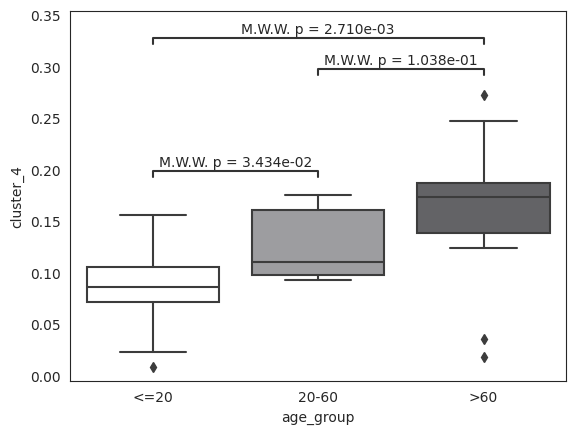

In [50]:
for i in [1, 4]:
    plt.figure()
    ax = sns.boxplot(
        data=community_with_age,
        x="age_group",
        y=f"cluster_{i}",
        order=["<=20", "20-60", ">60"],
        palette=age_group_palette,
    )
    pairs = list(combinations(["<=20", "20-60", ">60"], 2))

    annotator = Annotator(
        ax,
        pairs,
        data=community_with_age,
        x="age_group",
        y=f"cluster_{i}",
        order=["<=20", "20-60", ">60"],
    )
    annotator.configure(test="Mann-Whitney-ls", text_format="full", loc="inside")
    annotator.apply_and_annotate()

    print(community_with_age.groupby("age_group").agg({f"cluster_{i}": "describe"}))

    plt.show()
    plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.833e-01 U_stat=3.300e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.734e-01 U_stat=4.700e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.697e-03 U_stat=1.180e+02


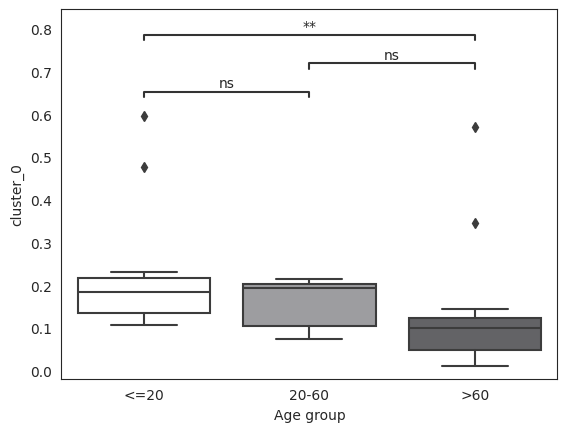

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.974e-02 U_stat=1.200e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.750e-01 U_stat=2.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.129e-03 U_stat=2.000e+01


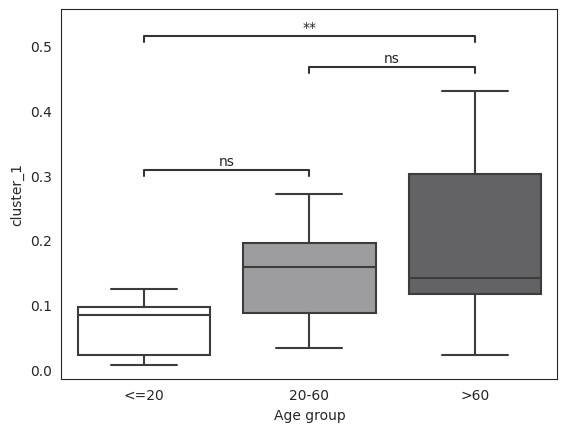

In [51]:
for i in range(0, 2):
    plt.figure()
    ax = sns.boxplot(
        data=community_with_age,
        x="age_group",
        y=f"cluster_{i}",
        order=["<=20", "20-60", ">60"],
        palette=age_group_palette,
    )
    pairs = list(combinations(["<=20", "20-60", ">60"], 2))
    plt.xlabel("Age group")

    annotator = Annotator(
        ax,
        pairs,
        data=community_with_age,
        x="age_group",
        y=f"cluster_{i}",
        order=["<=20", "20-60", ">60"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

In [52]:
community_cell_fraction_with_age = community_cell_fraction.copy()
community_cell_fraction_with_age[
    "age_at_dx"
] = community_cell_fraction_with_age.index.to_series().map(case_id_age_mapping)

community_cell_fraction_with_age[
    "age_group"
] = community_cell_fraction_with_age.index.to_series().map(case_id_age_group_mapping)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test smaller, P_val:1.900e-02 U_stat=9.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:3.165e-01 U_stat=2.700e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:1.068e-03 U_stat=1.800e+01


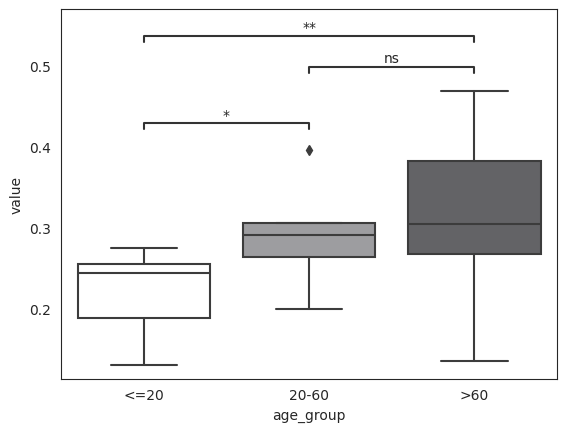

In [53]:
cell_type = "Non-hematopoietic elements"

df = community_cell_fraction_with_age.pivot(columns="age_group", values=cell_type)

df = df.reset_index(drop=True).melt().dropna()

ax = sns.boxplot(
    data=df,
    x="age_group",
    y="value",
    order=["<=20", "20-60", ">60"],
    palette=age_group_palette,
)
pairs = list(combinations(["<=20", "20-60", ">60"], 2))

annotator = Annotator(
    ax, pairs, data=df, x="age_group", y="value", order=["<=20", "20-60", ">60"]
)
annotator.configure(test="Mann-Whitney-ls", text_format="star", loc="inside")
annotator.apply_and_annotate()

plt.show()
plt.close()

In [71]:
for cell_type in cell_typing.obs["cell_type"].cat.categories:
    print(
        cell_type,
        stats.spearmanr(
            community_cell_fraction_with_age[cell_type],
            community_cell_fraction_with_age["age_at_dx"].astype(float),
        ),
        stats.pearsonr(
            community_cell_fraction_with_age[cell_type],
            community_cell_fraction_with_age["age_at_dx"],
        ),
    )

B-cell precursor SignificanceResult(statistic=-0.3713019557078835, pvalue=0.047355299699537265) PearsonRResult(statistic=-0.24188300206435456, pvalue=0.20617437080592865)
Endothelium SignificanceResult(statistic=0.28106522543624646, pvalue=0.1396849459135129) PearsonRResult(statistic=0.24702629001668566, pvalue=0.19639426636792723)
Erythroid Normoblasts SignificanceResult(statistic=0.15803755219704738, pvalue=0.4129080469487356) PearsonRResult(statistic=0.10992856124707266, pvalue=0.5702599603722398)
HSPC SignificanceResult(statistic=0.10774166975056114, pvalue=0.5779999471689867) PearsonRResult(statistic=0.008445804333297717, pvalue=0.9653172467847588)
Mast cells SignificanceResult(statistic=-0.4950692742771779, pvalue=0.006324669230299534) PearsonRResult(statistic=-0.5568314045576532, pvalue=0.0017047804483288024)
Maturing myeloid cells SignificanceResult(statistic=-0.48939866007978, pvalue=0.007050960440765916) PearsonRResult(statistic=-0.3572537537353349, pvalue=0.05709641463377979

### PCC & SCC for different cell types and age at dx

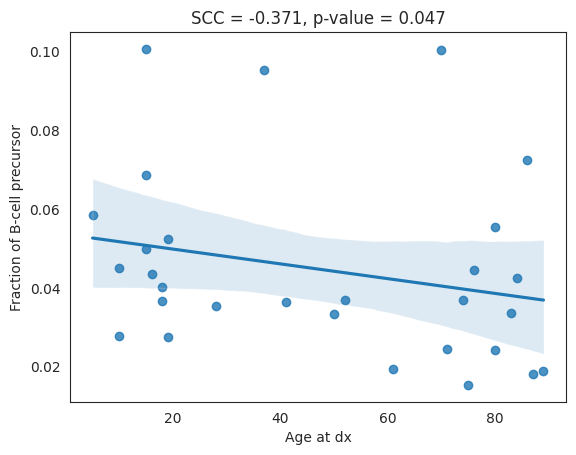

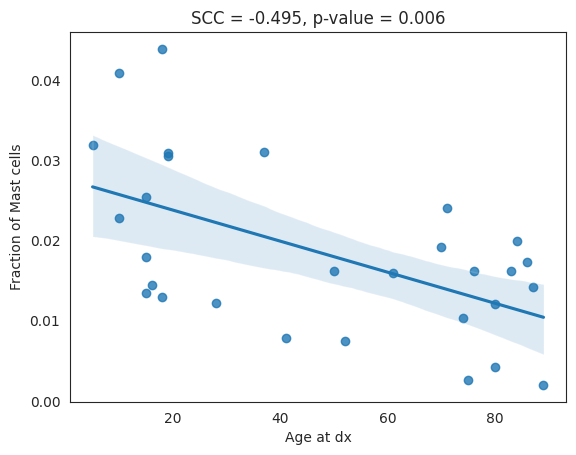

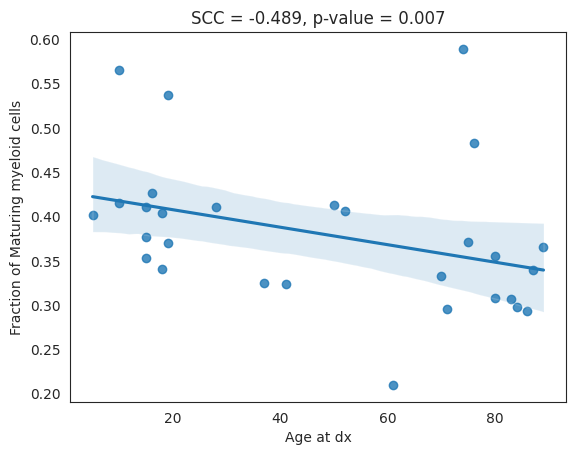

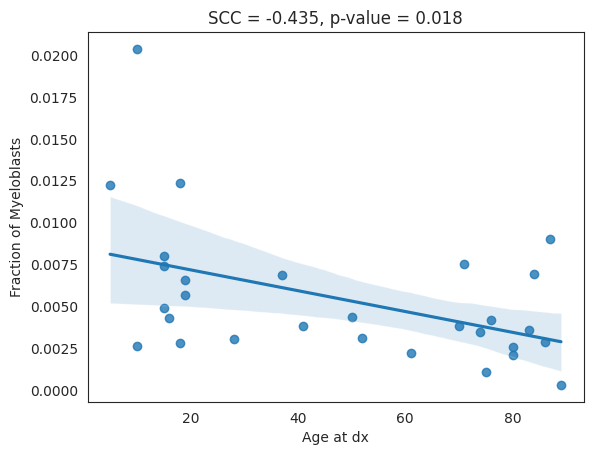

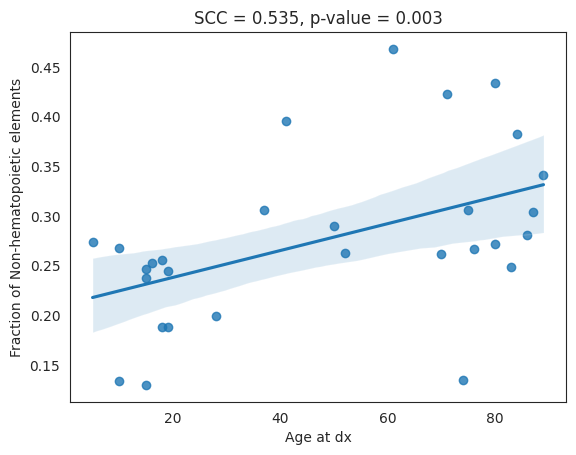

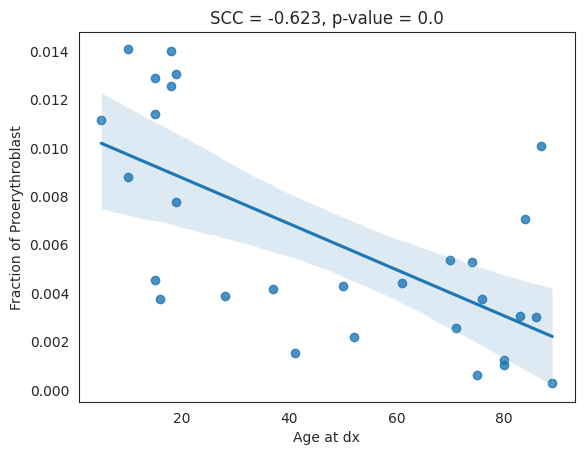

In [54]:
for cell_type in cell_typing.obs["cell_type"].cat.categories:
    scc, scc_p = stats.spearmanr(
        community_cell_fraction_with_age[cell_type],
        community_cell_fraction_with_age["age_at_dx"].astype(float),
    )
    pcc, pcc_p = stats.pearsonr(
        community_cell_fraction_with_age[cell_type],
        community_cell_fraction_with_age["age_at_dx"],
    )

    if scc_p <= 0.05:
        plt.figure()

        sns.regplot(
            y=community_cell_fraction_with_age[cell_type],
            x=community_cell_fraction_with_age["age_at_dx"].astype(float),
        )
        plt.xlabel("Age at dx")
        plt.ylabel(f"Fraction of {cell_type}")
        plt.title(f"SCC = {round(scc, 3)}, p-value = {round(scc_p, 3)}")

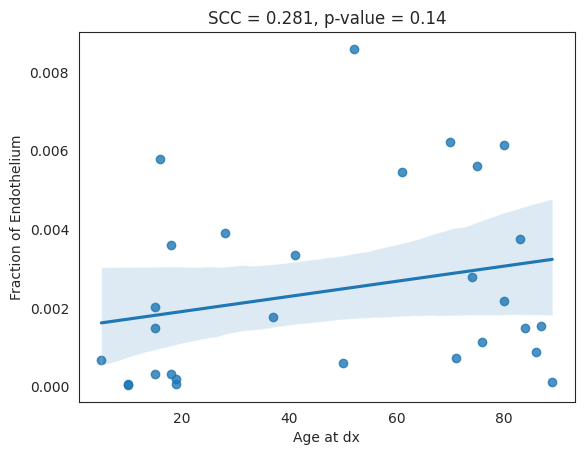

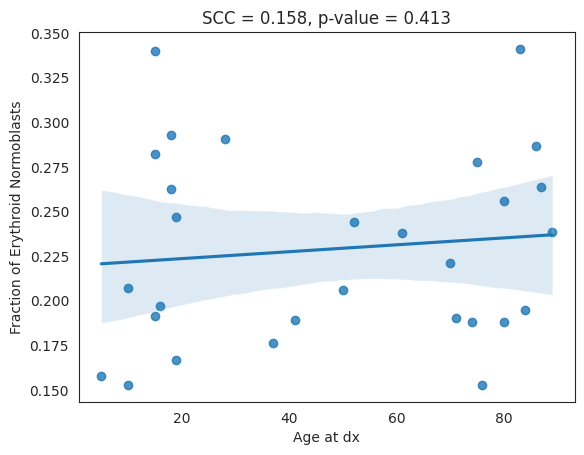

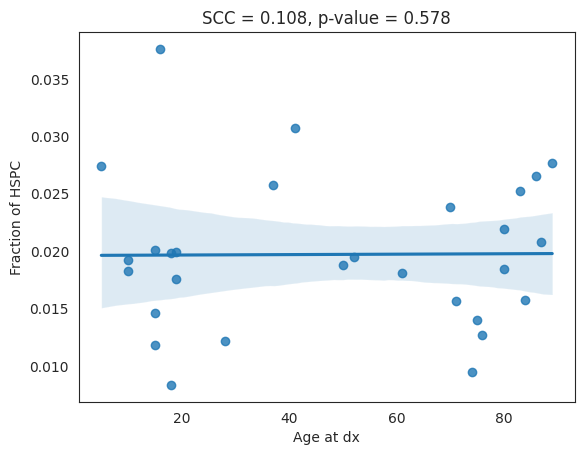

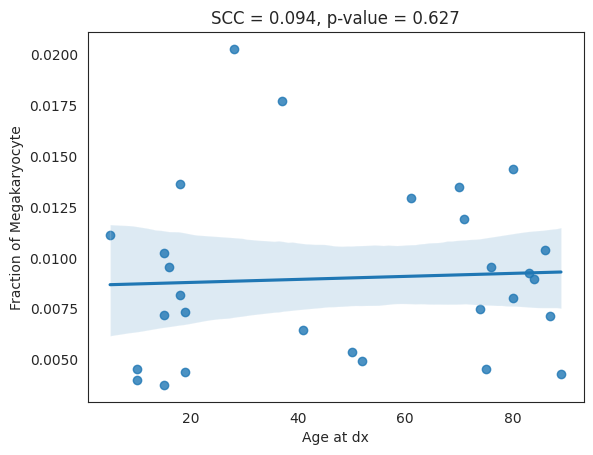

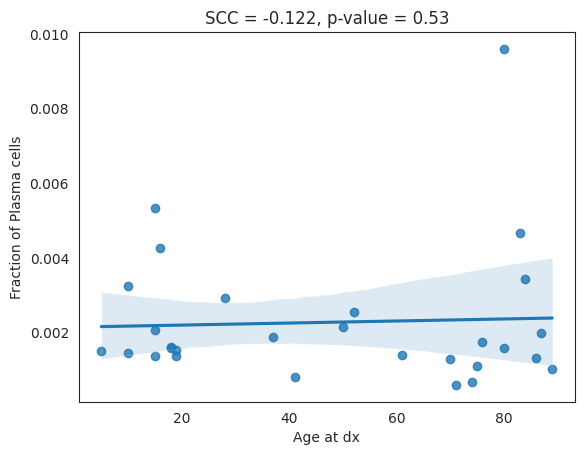

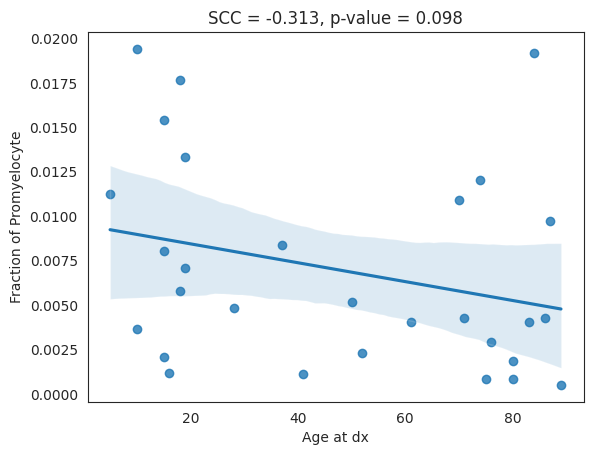

In [55]:
for cell_type in cell_typing.obs["cell_type"].cat.categories:
    scc, scc_p = stats.spearmanr(
        community_cell_fraction_with_age[cell_type],
        community_cell_fraction_with_age["age_at_dx"].astype(float),
    )
    pcc, pcc_p = stats.pearsonr(
        community_cell_fraction_with_age[cell_type],
        community_cell_fraction_with_age["age_at_dx"],
    )

    if scc_p > 0.05:
        plt.figure()

        sns.regplot(
            y=community_cell_fraction_with_age[cell_type],
            x=community_cell_fraction_with_age["age_at_dx"].astype(float),
        )
        plt.xlabel("Age at dx")
        plt.ylabel(f"Fraction of {cell_type}")
        plt.title(f"SCC = {round(scc, 3)}, p-value = {round(scc_p, 3)}")

### Make sure there is no differences for HSPC

In [56]:
stats.spearmanr(
    community_cell_fraction_with_age["HSPC"],
    community_cell_fraction_with_age["age_at_dx"].astype(float),
), stats.pearsonr(
    community_cell_fraction_with_age["HSPC"],
    community_cell_fraction_with_age["age_at_dx"],
)

(SignificanceResult(statistic=0.10774166975056114, pvalue=0.5779999471689867),
 PearsonRResult(statistic=0.008445804333297717, pvalue=0.9653172467847588))

Text(0.5, 0, 'HSPC fraction')

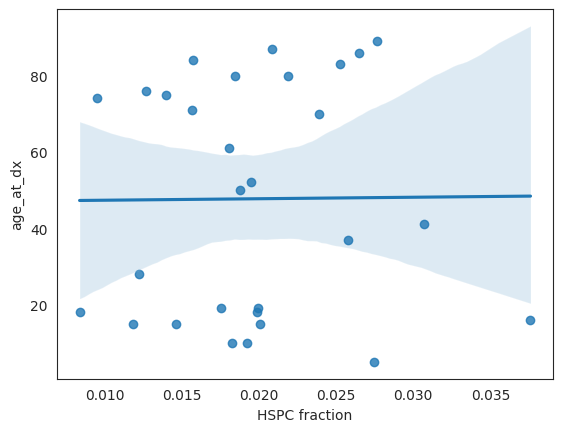

In [57]:
sns.regplot(
    x=community_cell_fraction_with_age["HSPC"],
    y=community_cell_fraction_with_age["age_at_dx"],
)
plt.xlabel("HSPC fraction")

### Check cell type size and density differences in different age groups

In [59]:
cell_size = cell_typing.obs.groupby(
    ["age_group", "case_id", "cell_type"], as_index=True
).agg({"cell_index": "nunique"})

cell_size = cell_size.reset_index().dropna().reset_index(drop=True)

cell_size = cell_size[cell_size["cell_index"] != 0]

total_cell_num = cell_typing.obs.groupby(["case_id", "age_group"], as_index=True).agg(
    {"cell_index": "count"}
)

total_cell_num = total_cell_num.reset_index()

total_cell_num = total_cell_num[total_cell_num["cell_index"] != 0].reset_index(
    drop=True
)

total_cell_num["tissue"] = total_cell_num["case_id"].map(case_id_tissue_area_mapping)

total_cell_num["density"] = total_cell_num["cell_index"].astype(float) / total_cell_num[
    "tissue"
].astype(float)

patient_cell_counts = patient_cell_counts.reindex(total_cell_num["case_id"])

hspc_count = (
    cell_size[cell_size["cell_type"] == "HSPC"]
    .set_index("case_id")["cell_index"]
    .to_dict()
)

total_cell_num["Normalized HSPC %"] = patient_cell_counts["HSPC"].astype(
    np.float32
).values / total_cell_num["density"].astype(np.float32)

total_cell_num["hspc_count"] = total_cell_num["case_id"].map(hspc_count)

total_cell_num["Normalized HSPC absolute number"] = (
    total_cell_num["hspc_count"].astype(float) / total_cell_num["density"]
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test smaller, P_val:2.747e-03 U_stat=4.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:9.825e-01 U_stat=5.300e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:3.187e-02 U_stat=3.900e+01


(<Axes: xlabel='Age group', ylabel='HSPC per squared mm'>,
  <statannotations.Annotation.Annotation at 0x7f388d0da1a0>])

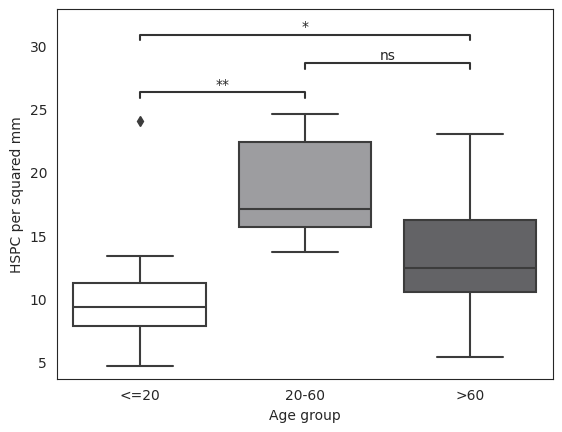

In [60]:
ax = sns.boxplot(
    data=total_cell_num,
    x="age_group",
    y=f"Normalized HSPC %",
    order=["<=20", "20-60", ">60"],
    palette=age_group_palette,
)
pairs = list(combinations(["<=20", "20-60", ">60"], 2))
plt.ylabel(f"HSPC per squared mm")
plt.xlabel("Age group")

annotator = Annotator(
    ax,
    pairs,
    data=total_cell_num,
    x="age_group",
    y=f"Normalized HSPC %",
    order=["<=20", "20-60", ">60"],
)
annotator.configure(test="Mann-Whitney-ls", text_format="star", loc="inside")
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test greater, P_val:9.984e-01 U_stat=4.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test greater, P_val:2.299e-02 U_stat=5.300e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test greater, P_val:9.721e-01 U_stat=3.900e+01


(<Axes: xlabel='Age group', ylabel='HSPC per squared mm'>,
  <statannotations.Annotation.Annotation at 0x7f3874d34eb0>])

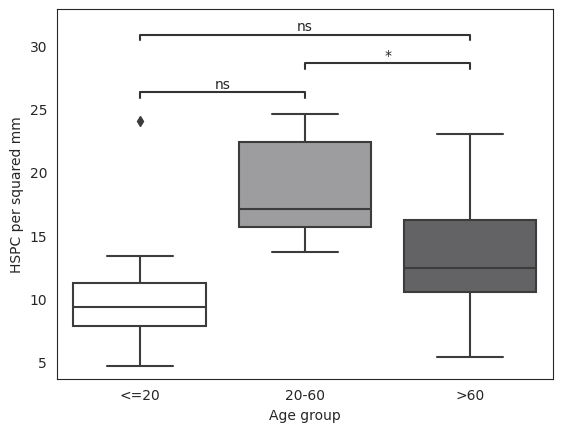

In [61]:
ax = sns.boxplot(
    data=total_cell_num,
    x="age_group",
    y=f"Normalized HSPC %",
    order=["<=20", "20-60", ">60"],
    palette=age_group_palette,
)
pairs = list(combinations(["<=20", "20-60", ">60"], 2))
plt.ylabel(f"HSPC per squared mm")
plt.xlabel("Age group")

annotator = Annotator(
    ax,
    pairs,
    data=total_cell_num,
    x="age_group",
    y=f"Normalized HSPC %",
    order=["<=20", "20-60", ">60"],
)
annotator.configure(test="Mann-Whitney-gt", text_format="star", loc="inside")
annotator.apply_and_annotate()

In [62]:
cell_size["mmsq"] = cell_size["case_id"].map(case_id_tissue_area_mapping).astype(float)

In [63]:
cell_size["normalized_hspc_count"] = cell_size["cell_index"] / cell_size["mmsq"]

In [64]:
hspc_cell_area = cell_size[cell_size["cell_type"] == "HSPC"]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.451e-01 U_stat=4.100e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.028e-01 U_stat=2.500e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.178e-01 U_stat=9.900e+01


(<Axes: xlabel='Age group', ylabel='Normalized HSPC count, cells per mm squared'>,
  <statannotations.Annotation.Annotation at 0x7f38748d31f0>])

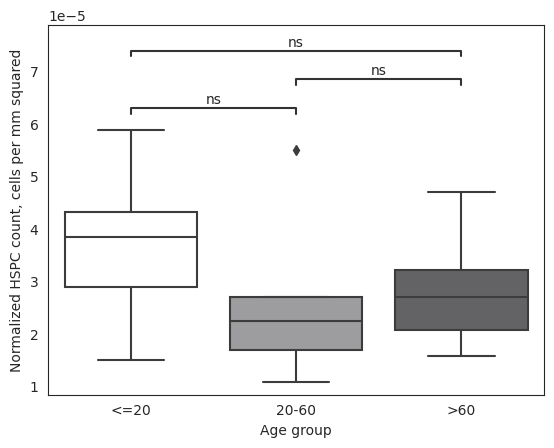

In [65]:
ax = sns.boxplot(
    data=hspc_cell_area,
    x="age_group",
    y=f"normalized_hspc_count",
    order=["<=20", "20-60", ">60"],
    palette=age_group_palette,
)
pairs = list(combinations(["<=20", "20-60", ">60"], 2))
plt.ylabel(f"Normalized HSPC count, cells per mm squared")
plt.xlabel("Age group")

annotator = Annotator(
    ax,
    pairs,
    data=hspc_cell_area,
    x="age_group",
    y=f"normalized_hspc_count",
    order=["<=20", "20-60", ">60"],
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.451e-01 U_stat=1.400e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.241e-01 U_stat=3.400e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.700e-02 U_stat=3.500e+01


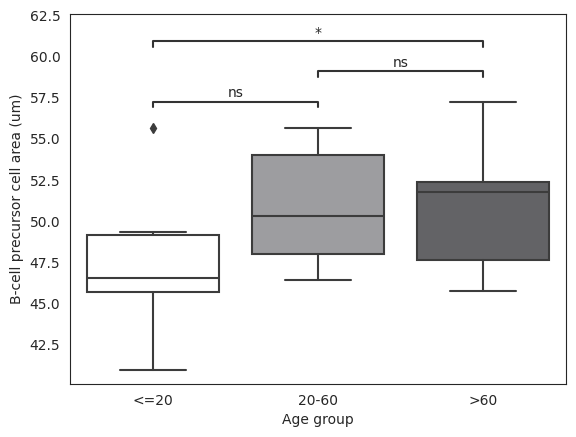

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.923e-02 U_stat=7.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.873e-01 U_stat=4.200e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-01 U_stat=4.600e+01


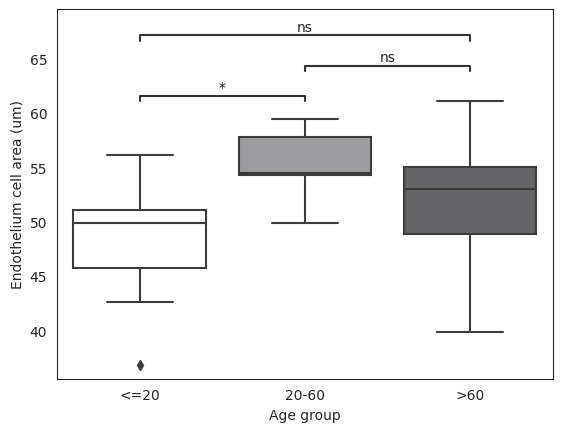

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.833e-01 U_stat=2.200e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.490e-01 U_stat=3.000e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.848e-01 U_stat=5.600e+01


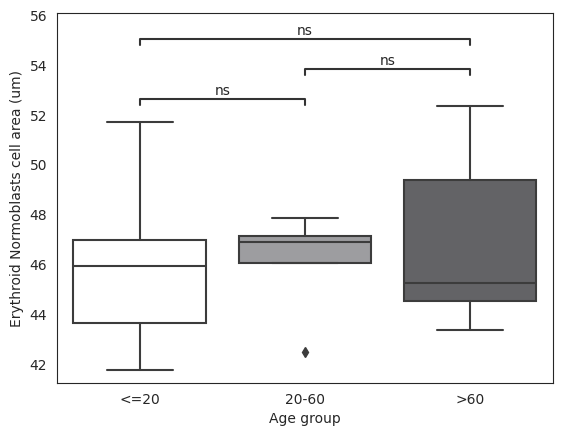

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.700e-03 U_stat=5.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.460e-01 U_stat=4.500e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.385e-02 U_stat=3.200e+01


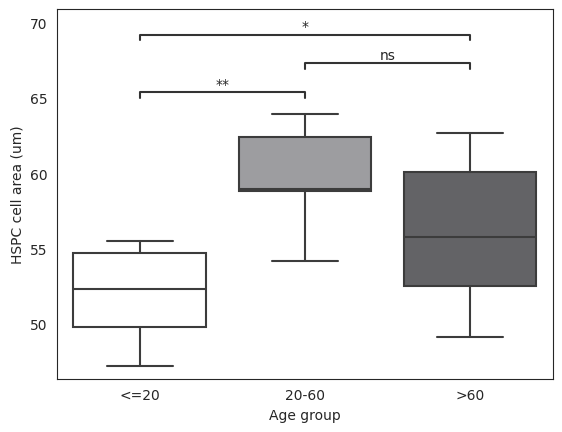

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.700e-03 U_stat=5.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:4.430e-01 U_stat=4.100e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.178e-01 U_stat=4.400e+01


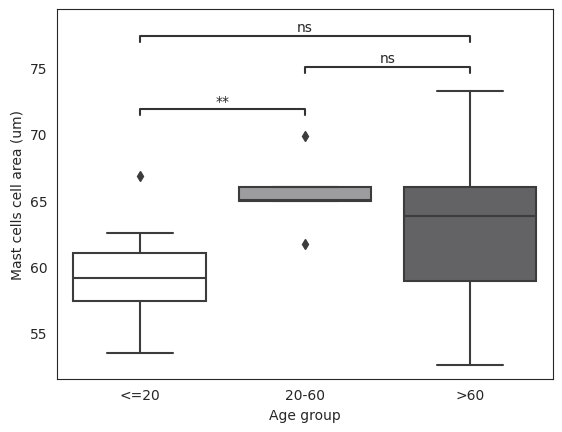

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.269e-01 U_stat=3.000e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.750e-01 U_stat=2.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.167e-01 U_stat=6.700e+01


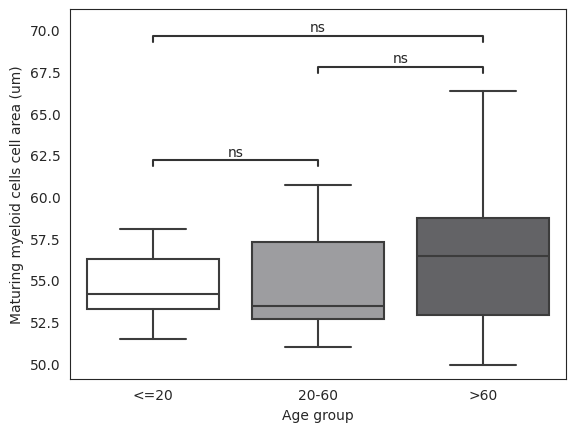

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.833e-01 U_stat=2.200e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:4.435e-03 U_stat=6.000e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.589e-03 U_stat=1.240e+02


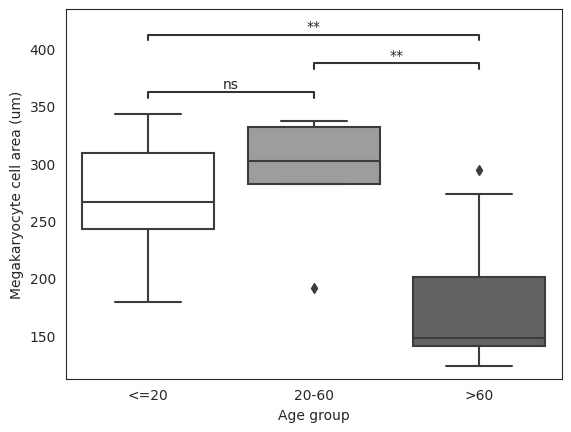

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:4.579e-04 U_stat=0.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.460e-01 U_stat=4.500e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.273e-02 U_stat=2.800e+01


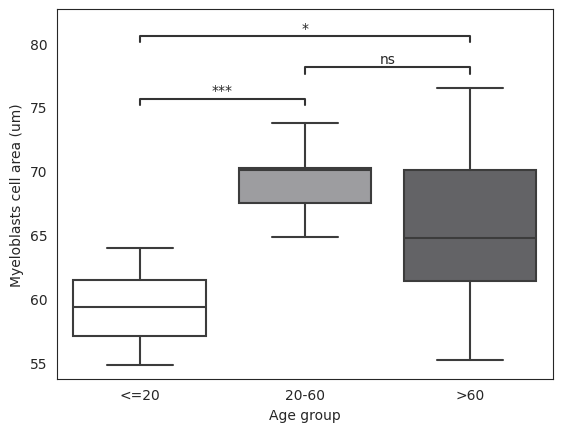

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:6.612e-01 U_stat=2.300e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.241e-01 U_stat=3.400e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.239e-01 U_stat=6.000e+01


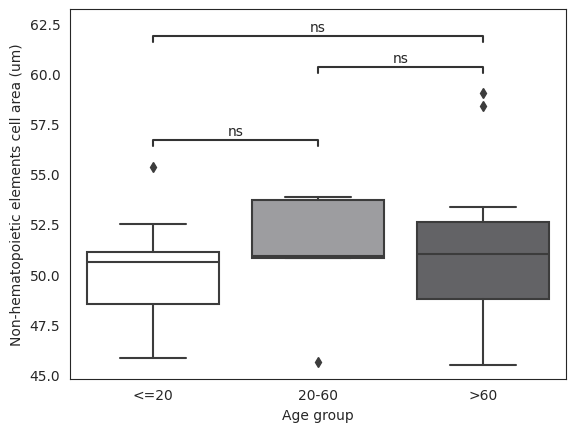

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.096e-01 U_stat=2.100e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.028e-01 U_stat=3.700e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=7.100e+01


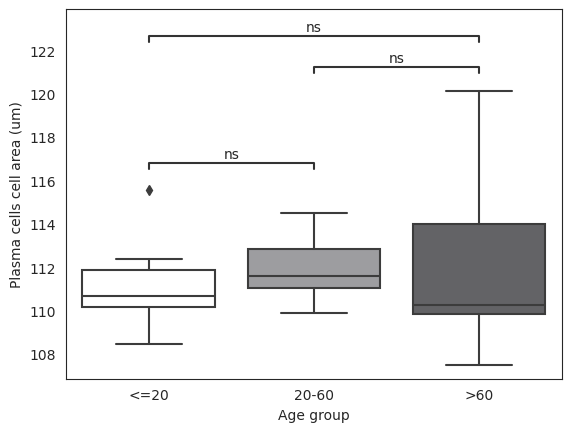

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.804e-01 U_stat=1.500e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.241e-01 U_stat=3.100e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.293e-02 U_stat=4.200e+01


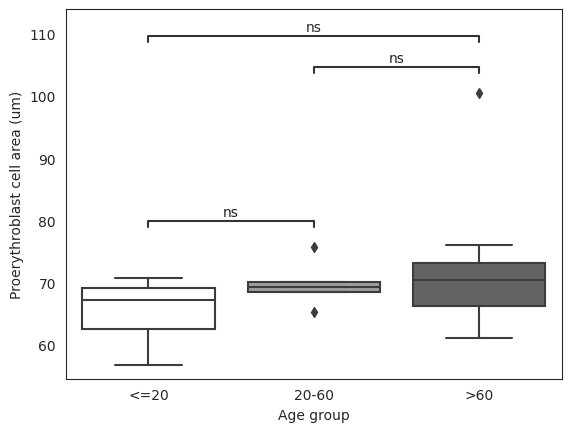

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.923e-02 U_stat=7.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.663e-01 U_stat=3.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.700e-02 U_stat=3.500e+01


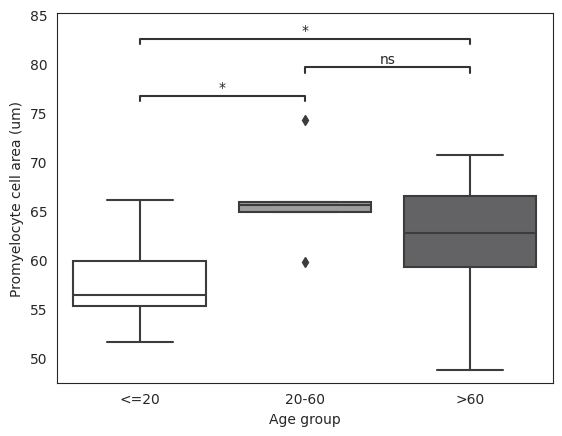

In [66]:
mean_cell_size = (
    cell_typing.obs.groupby(["cell_type", "age_group", "case_id"])["cell_area_um"]
    .mean()
    .reset_index()
)

for cell_type, cell_type_data in mean_cell_size.groupby("cell_type"):
    plt.figure()
    ax = sns.boxplot(
        data=cell_type_data,
        x="age_group",
        y=f"cell_area_um",
        order=["<=20", "20-60", ">60"],
        palette=age_group_palette,
    )
    pairs = list(combinations(["<=20", "20-60", ">60"], 2))
    plt.ylabel(f"{cell_type} cell area (um)")
    plt.xlabel("Age group")

    annotator = Annotator(
        ax,
        pairs,
        data=cell_type_data,
        x="age_group",
        y=f"cell_area_um",
        order=["<=20", "20-60", ">60"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

# Cell size group by gender

In [67]:
cell_size_by_gender_by_age_group = (
    cell_typing.obs.groupby(
        ["gender", "case_id", "cell_type"], as_index=True, observed=True
    )["cell_area_um"]
    .mean()
    .reset_index()
)

In [68]:
case_id_gender_mapping = (
    clinical_annotation[
        clinical_annotation["case_id"].isin(cell_typing.obs["case_id"].unique())
    ]
    .set_index("case_id")
    .to_dict()["gender"]
)

In [69]:
community_cell_fraction["gender"] = community_cell_fraction.index.map(
    case_id_gender_mapping
)

### Check whether observed results is due to gender

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:7.093e-01 U_stat=9.500e+01


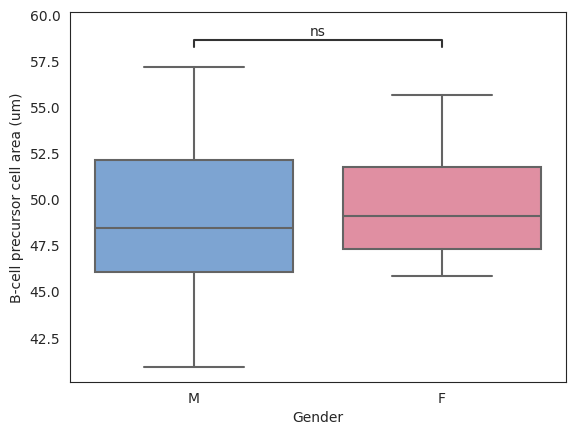

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:3.458e-01 U_stat=8.200e+01


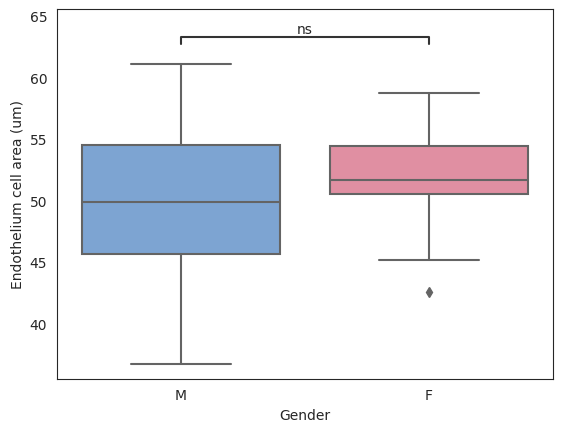

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.418e-01 U_stat=7.000e+01


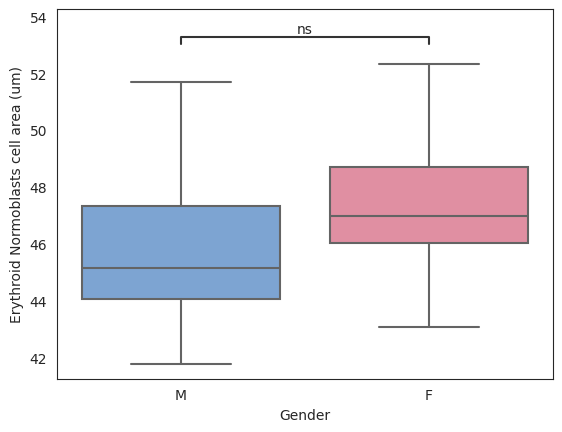

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:7.093e-01 U_stat=9.500e+01


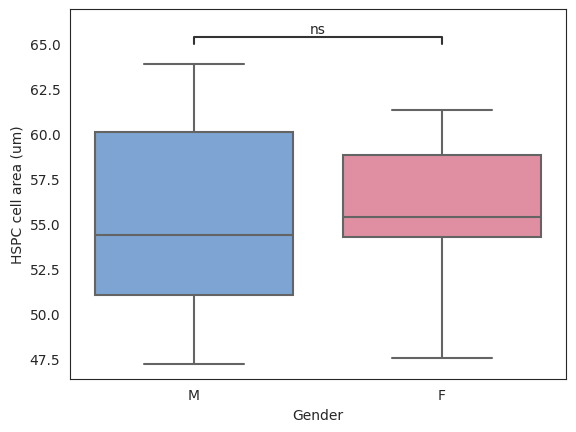

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:2.114e-01 U_stat=7.500e+01


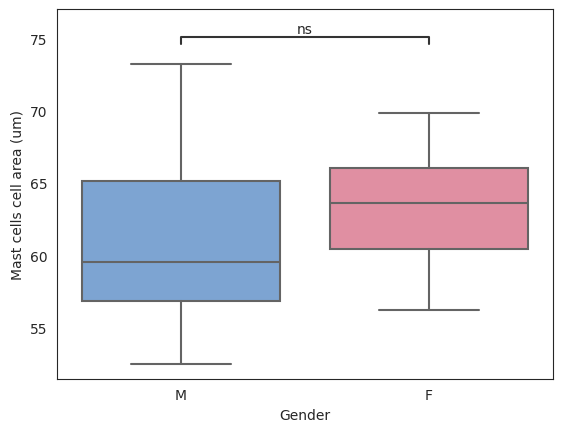

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:8.094e-01 U_stat=9.800e+01


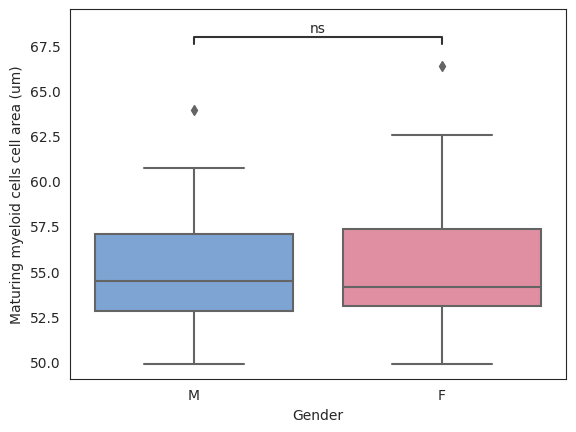

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:2.635e-01 U_stat=7.800e+01


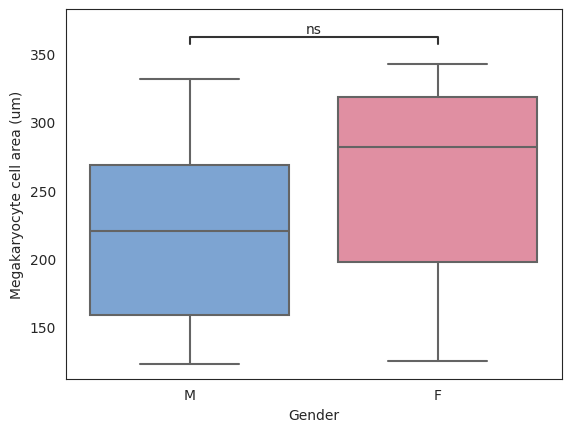

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:8.094e-01 U_stat=9.800e+01


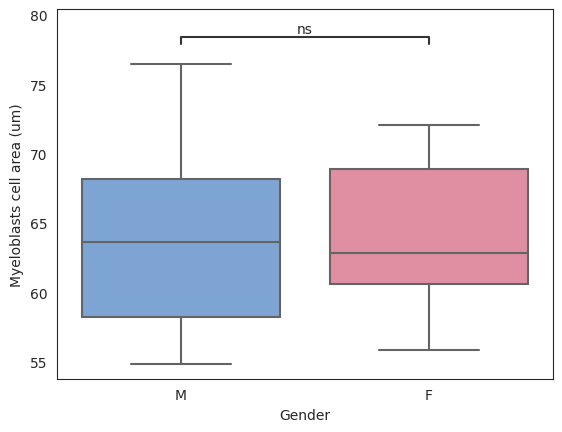

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.195e-01 U_stat=6.800e+01


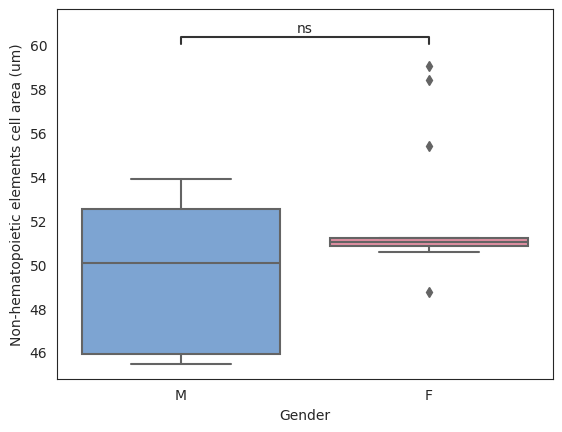

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:6.770e-01 U_stat=9.400e+01


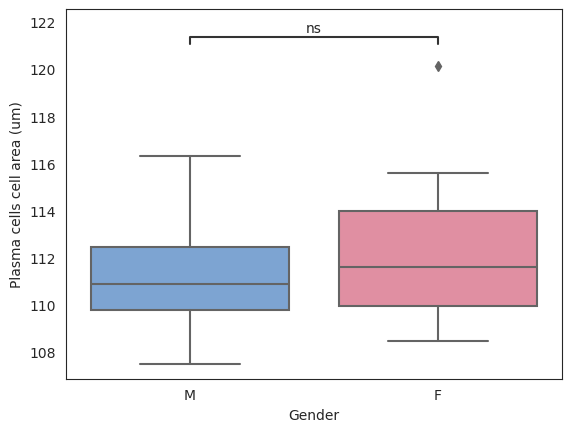

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:8.094e-01 U_stat=9.800e+01


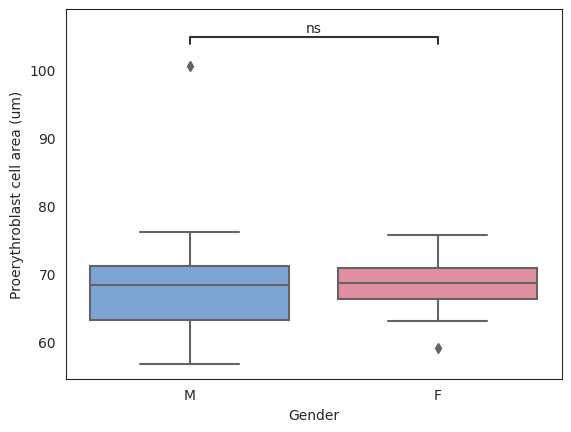

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:4.693e-01 U_stat=8.700e+01


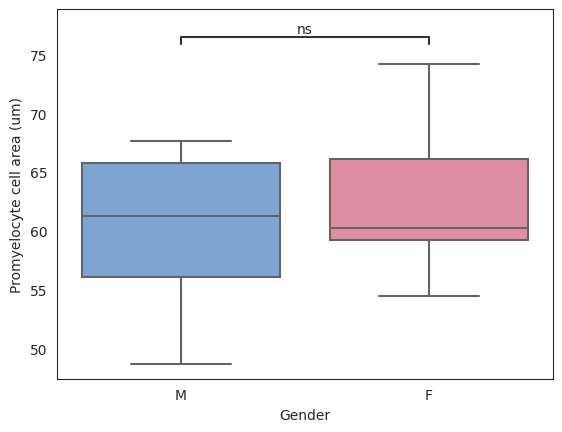

In [70]:
for cell_type, cell_type_data in cell_size_by_gender_by_age_group.groupby("cell_type"):
    plt.figure()
    ax = sns.boxplot(
        data=cell_type_data,
        x="gender",
        y=f"cell_area_um",
        order=["M", "F"],
        palette=gender_palette,
    )
    pairs = list(combinations(["M", "F"], 2))
    plt.ylabel(f"{cell_type} cell area (um)")
    plt.xlabel("Gender")

    annotator = Annotator(
        ax,
        pairs,
        data=cell_type_data,
        x="gender",
        y=f"cell_area_um",
        order=["M", "F"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Plasma cells_M vs. Plasma cells_F: Mann-Whitney-Wilcoxon test two-sided, P_val:3.925e-01 U_stat=8.400e+01
Proerythroblast_M vs. Proerythroblast_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.958e-01 U_stat=7.400e+01
Promyelocyte_M vs. Promyelocyte_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.958e-01 U_stat=7.400e+01
Non-hematopoietic elements_M vs. Non-hematopoietic elements_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.418e-01 U_stat=1.380e+02
Endothelium_M vs. Endothelium_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.195e-01 U_stat=6.800e+01
B-cell precursor_M vs. B-cell precursor_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.303e-01 U_stat=6.900e+01
Erythroid Normoblasts_M vs. Erythroid Normoblasts_F: Mann-Whitney-Wilcoxon test two-sided, P_val:9.127e-01 U_stat=1.010e+02
HSPC_M v

Text(42.722222222222214, 0.5, 'Fraction of cell type')

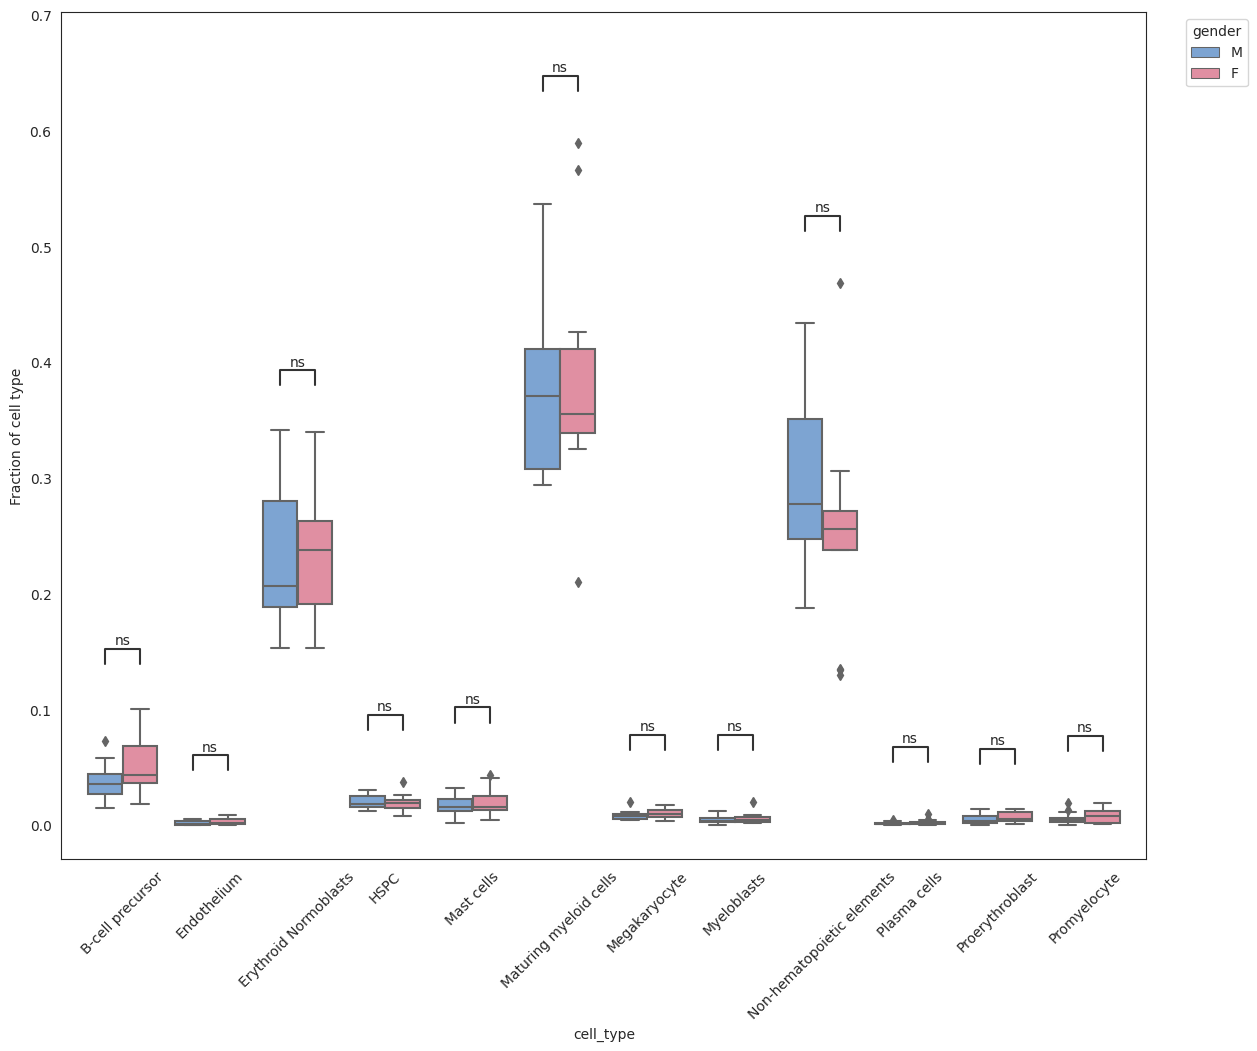

In [71]:
x = "cell_type"
y = "value"
hue = "gender"

hue_order = ["M", "F"]

pairs = [
    ((cell_type, "M"), (cell_type, "F"))
    for cell_type in community_cell_fraction.reset_index()
    .melt(id_vars=["case_id", "gender"])[x]
    .unique()
]

ax = sns.boxplot(
    data=community_cell_fraction.reset_index().melt(id_vars=["case_id", "gender"]),
    x=x,
    y=y,
    hue=hue,
    hue_order=hue_order,
    palette=gender_palette,
)

annotator = Annotator(
    ax,
    pairs,
    data=community_cell_fraction.reset_index().melt(id_vars=["case_id", "gender"]),
    x=x,
    y=y,
    hue_order=hue_order,
    hue=hue,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()
plt.legend(loc="upper left", bbox_to_anchor=(1.03, 1), title=hue)
plt.xticks(rotation=45)
plt.gcf().set_size_inches((14, 11))
plt.ylabel("Fraction of cell type")

In [72]:
community_with_age["gender"] = community_with_age.index.map(case_id_gender_mapping)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cluster_1_M vs. cluster_1_F: Mann-Whitney-Wilcoxon test two-sided, P_val:5.249e-01 U_stat=1.190e+02
cluster_0_M vs. cluster_0_F: Mann-Whitney-Wilcoxon test two-sided, P_val:4.693e-01 U_stat=8.700e+01
cluster_2_M vs. cluster_2_F: Mann-Whitney-Wilcoxon test two-sided, P_val:6.452e-01 U_stat=9.300e+01
cluster_3_M vs. cluster_3_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.541e-01 U_stat=7.100e+01
cluster_4_M vs. cluster_4_F: Mann-Whitney-Wilcoxon test two-sided, P_val:7.422e-01 U_stat=1.120e+02
cluster_5_M vs. cluster_5_F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.811e-01 U_stat=1.350e+02


Text(0.5, 23.38159722222222, 'Community cluster')

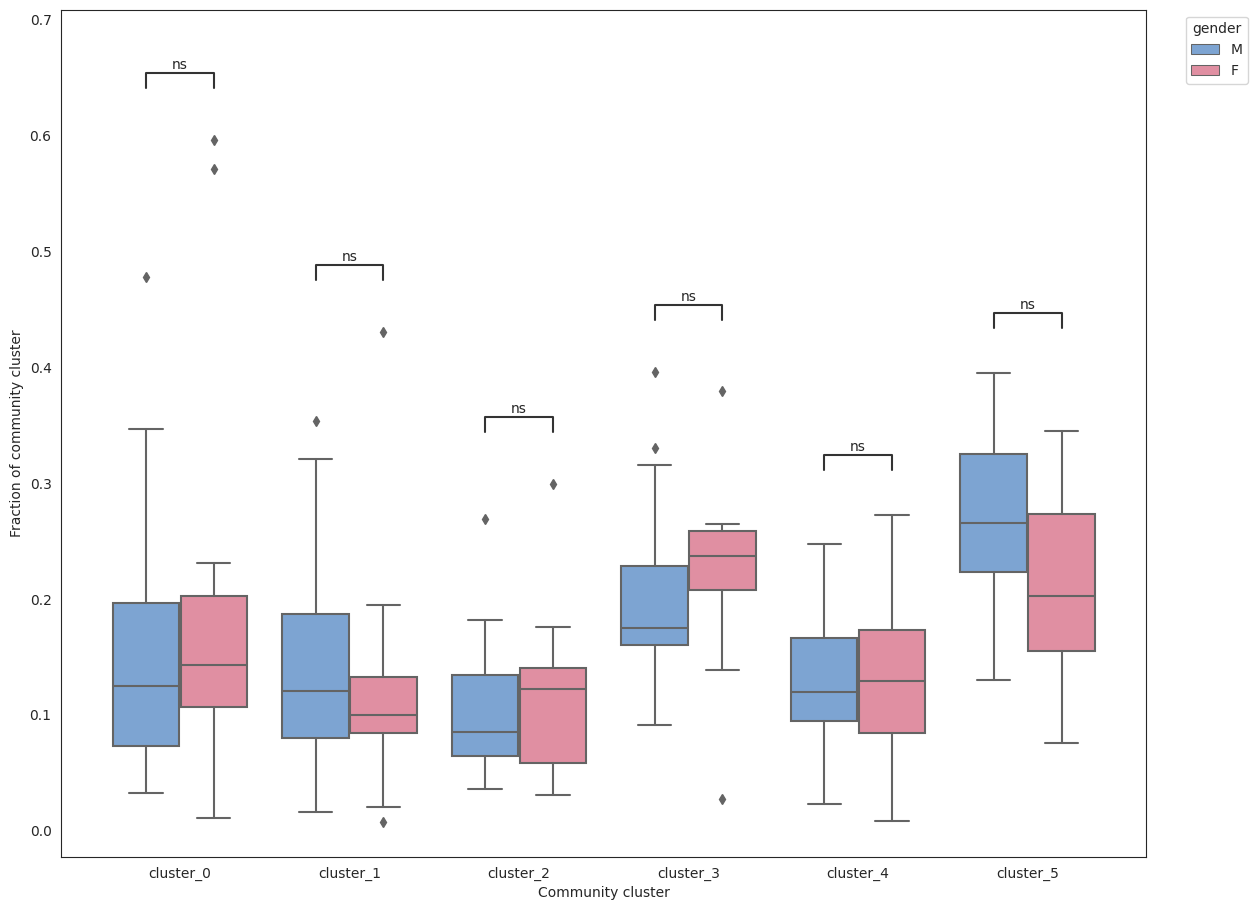

In [73]:
x = "graph_cluster"
y = "value"
hue = "gender"

hue_order = ["M", "F"]

pairs = [
    ((cell_type, "M"), (cell_type, "F"))
    for cell_type in community_with_age.reset_index()
    .melt(id_vars=["case_id", "gender", "age_group", "age_at_dx"])[x]
    .unique()
]

ax = sns.boxplot(
    data=community_with_age.reset_index().melt(
        id_vars=["case_id", "gender", "age_group", "age_at_dx"]
    ),
    x=x,
    y=y,
    hue=hue,
    hue_order=hue_order,
    palette=gender_palette,
)

annotator = Annotator(
    ax,
    pairs,
    data=community_with_age.reset_index().melt(
        id_vars=["case_id", "gender", "age_group", "age_at_dx"]
    ),
    x=x,
    y=y,
    hue_order=hue_order,
    hue=hue,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()
plt.legend(loc="upper left", bbox_to_anchor=(1.03, 1), title=hue)
# plt.xticks(rotation = 45)
plt.gcf().set_size_inches((14, 11))
plt.ylabel("Fraction of community cluster")
plt.xlabel("Community cluster")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:4.693e-01 U_stat=8.700e+01


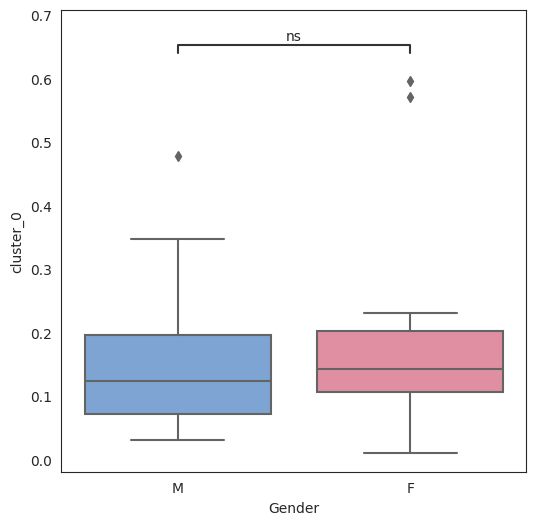

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:5.249e-01 U_stat=1.190e+02


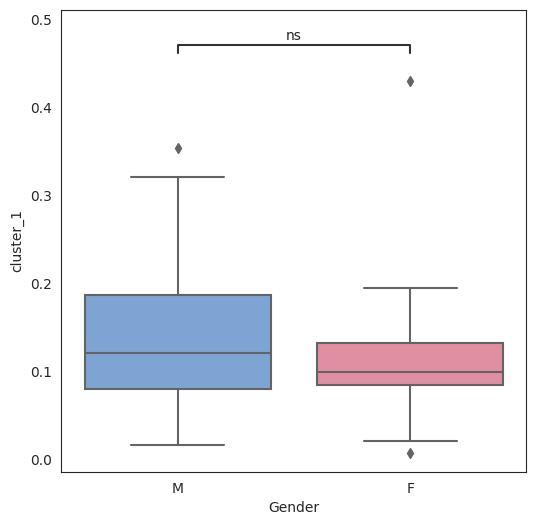

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:6.452e-01 U_stat=9.300e+01


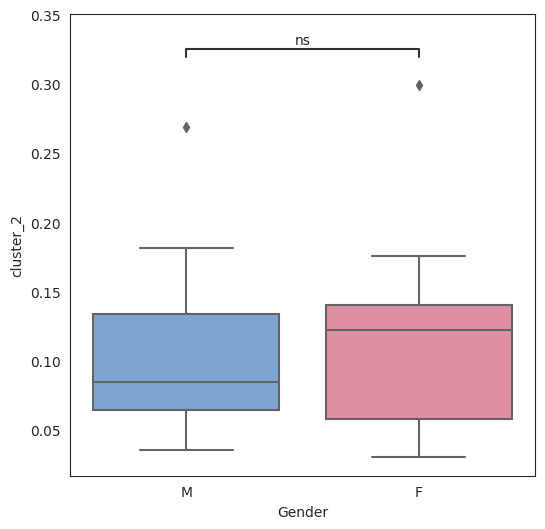

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.541e-01 U_stat=7.100e+01


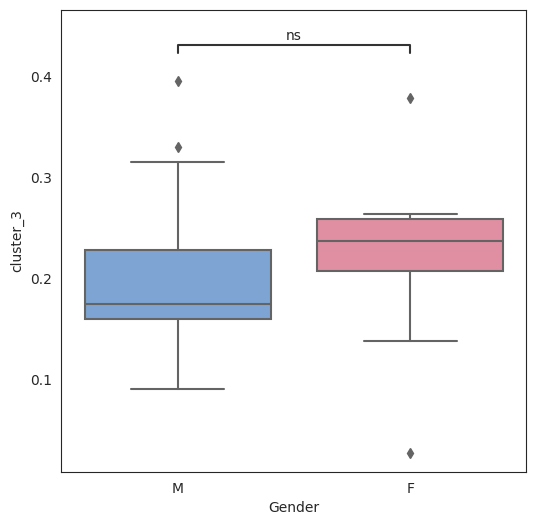

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:7.422e-01 U_stat=1.120e+02


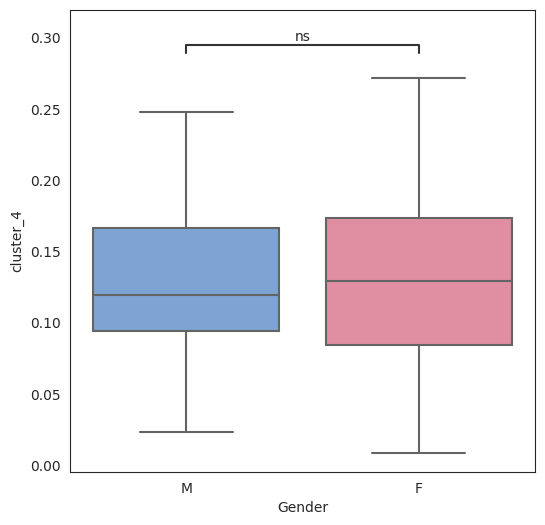

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:1.811e-01 U_stat=1.350e+02


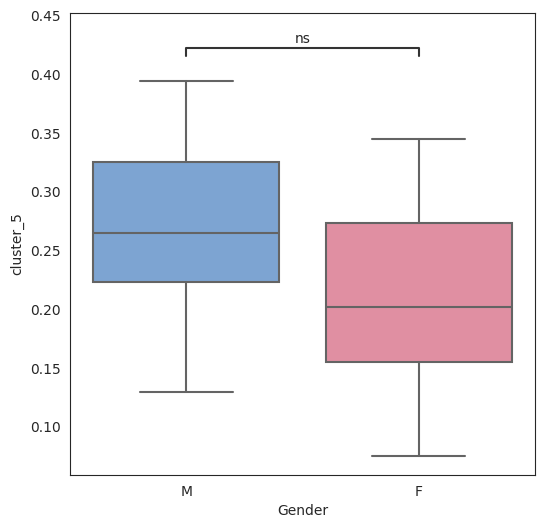

In [74]:
for i in range(0, 6):
    plt.figure()
    ax = sns.boxplot(
        data=community_with_age,
        x="gender",
        y=f"cluster_{i}",
        order=["M", "F"],
        palette=gender_palette,
    )
    pairs = list(combinations(["M", "F"], 2))
    plt.xlabel("Gender")

    annotator = Annotator(
        ax,
        pairs,
        data=community_with_age,
        x="gender",
        y=f"cluster_{i}",
        order=["M", "F"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()
    plt.gcf().set_size_inches((6, 6))

    plt.show()
    plt.close()

# Aspirates

In [79]:
aspirates = pd.read_excel("../data/Values_for_Panel_1F_correlations.xlsx", index_col=0)

In [80]:
patient_cell_counts.index = patient_cell_counts.index.astype(str)

In [81]:
patient_cell_counts = patient_cell_counts.loc[aspirates.index.tolist(), :]

In [82]:
stats.pearsonr(
    aspirates["M:E (Aspirate diff)"].dropna(),
    (
        patient_cell_counts["Maturing myeloid cells"]
        / patient_cell_counts["Erythroid Normoblasts"]
    ).reindex(aspirates["M:E (Aspirate diff)"].dropna().index),
), stats.spearmanr(
    aspirates["M:E (Aspirate diff)"].dropna(),
    (
        patient_cell_counts["Maturing myeloid cells"]
        / patient_cell_counts["Erythroid Normoblasts"]
    ).reindex(aspirates["M:E (Aspirate diff)"].dropna().index),
)

(PearsonRResult(statistic=0.5796840843289769, pvalue=0.002389253927638776),
 SignificanceResult(statistic=0.44624889921707855, pvalue=0.02535047125628401))

/home/asarachakov/python10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'MMC to Erythroid Normoblasts ratio')

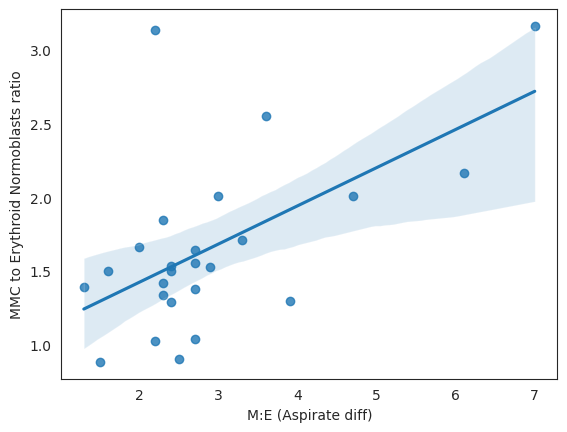

In [83]:
sns.regplot(
    aspirates["M:E (Aspirate diff)"].dropna(),
    (
        patient_cell_counts["Maturing myeloid cells"]
        / patient_cell_counts["Erythroid Normoblasts"]
    ).reindex(aspirates["M:E (Aspirate diff)"].dropna().index),
)
plt.ylabel("MMC to Erythroid Normoblasts ratio")

In [84]:
stats.pearsonr(
    aspirates["Blast cells (Aspirate diff)"].dropna(),
    (patient_cell_counts["HSPC"] + patient_cell_counts["Myeloblasts"]).reindex(
        aspirates["Blast cells (Aspirate diff)"].dropna().index
    ),
), stats.spearmanr(
    aspirates["Blast cells (Aspirate diff)"].dropna(),
    (patient_cell_counts["HSPC"] + patient_cell_counts["Myeloblasts"]).reindex(
        aspirates["Blast cells (Aspirate diff)"].dropna().index
    ),
)

(PearsonRResult(statistic=0.002805041225644997, pvalue=0.9891494986124169),
 SignificanceResult(statistic=-0.012952552609922374, pvalue=0.9499261080270895))

# Fat to cell

In [85]:
fat_to_age = cell_typing.obs.groupby("case_id")[
    ["age_at_dx", "fat_to_cell_amount"]
].mean()

In [86]:
stats.spearmanr(fat_to_age["age_at_dx"], fat_to_age["fat_to_cell_amount"])

SignificanceResult(statistic=0.42430987103138607, pvalue=0.021786180013067362)

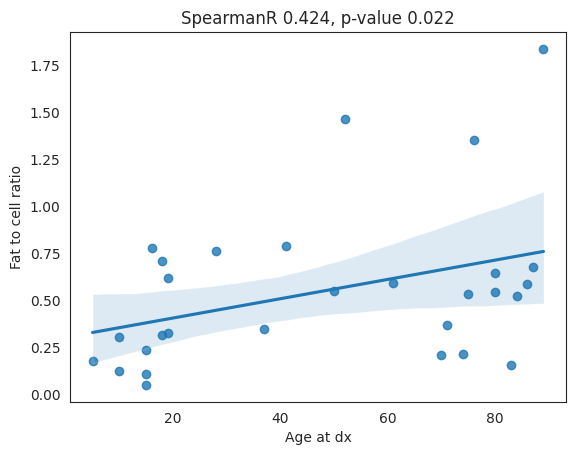

In [87]:
sns.regplot(data=fat_to_age, x="age_at_dx", y="fat_to_cell_amount")

plt.ylabel("Fat to cell ratio")
plt.xlabel("Age at dx")
plt.title(
    f"SpearmanR {round(stats.spearmanr(fat_to_age['age_at_dx'], fat_to_age['fat_to_cell_amount'])[0], 3)}, p-value {round(stats.spearmanr(fat_to_age['age_at_dx'], fat_to_age['fat_to_cell_amount'])[1], 3)}"
)

plt.show()
plt.close()

In [88]:
fat_to_age.index = fat_to_age.index.astype(str)

In [89]:
fat_to_age["age_group"] = fat_to_age["age_at_dx"].map(agify)

In [90]:
fat_so = sort_by_terms_order(
    data=fat_to_age["age_group"],
    vector=fat_to_age["fat_to_cell_amount"],
    t_order=["<=20", "20-60", ">60"],
)

### Visualize how fat-to-cell ration distributed in age groups

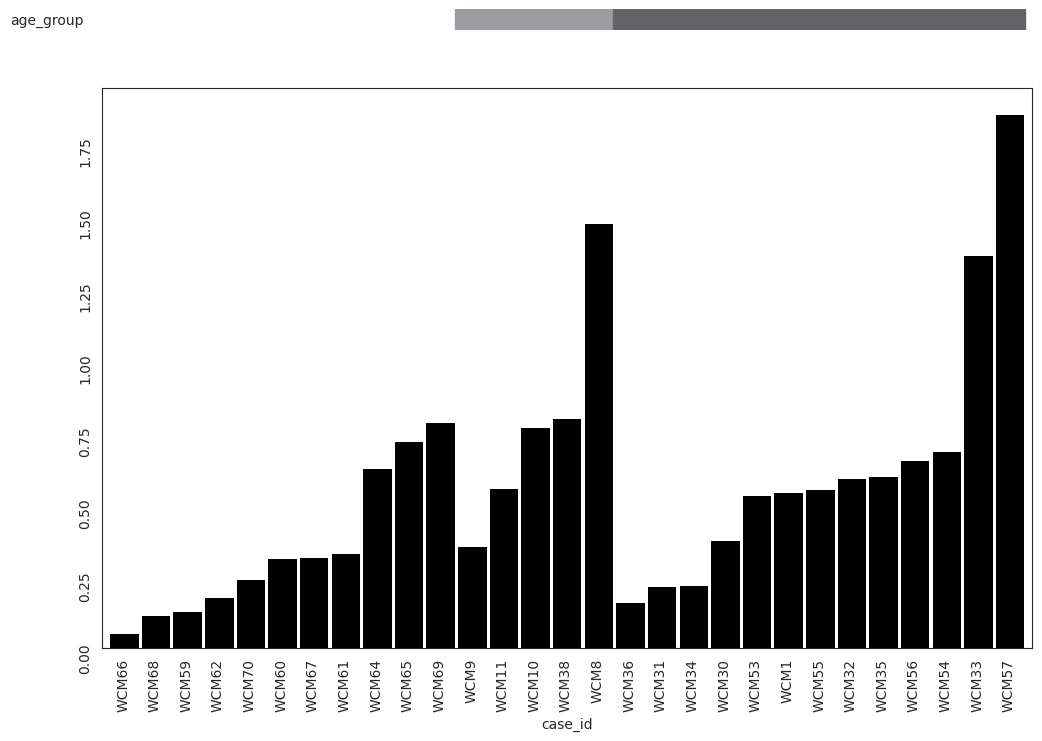

In [91]:
af = get_stacked_axes(ys=[0.3, 8], x_len=12)

line_palette_annotation_plot(
    val_vector=fat_to_age["age_group"][fat_so], palette=age_group_palette, ax=next(af)
)

ax = contingency_bar_plot(
    pd.DataFrame(fat_to_age.T.loc["fat_to_cell_amount", fat_so]),
    percent=False,
    legend=False,
    ax=next(af),
    palette={
        k: "#000000"
        for k in pd.DataFrame(fat_to_age.T.loc["fat_to_cell_amount", fat_so])
    },
)

ax.tick_params(axis="x", labelrotation=90)
ax.tick_params(axis="y", labelrotation=90)

In [92]:
fat_df = (
    cell_typing.obs[["case_id", "fat_to_cell_ratio"]]
    .drop_duplicates()
    .set_index("case_id")
)

In [93]:
community_with_fat = community_cell_percentages.join(fat_df)

In [94]:
fat_palette = {"low": "#FFDE81", "high": "#A7986C"}

In [95]:
plt.rcParams["figure.dpi"] = 90

### Check whether fat-to-cell ratio associated with cluster fraction

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:7.434e-01 U_stat=1.130e+02


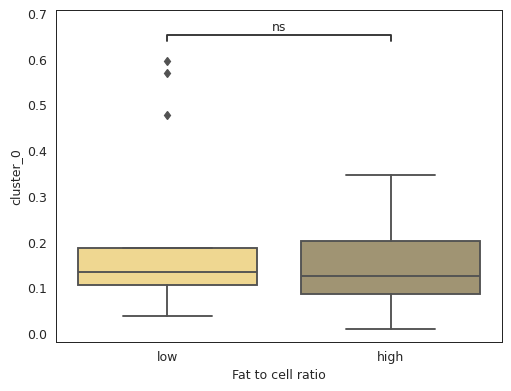

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:2.849e-01 U_stat=8.000e+01


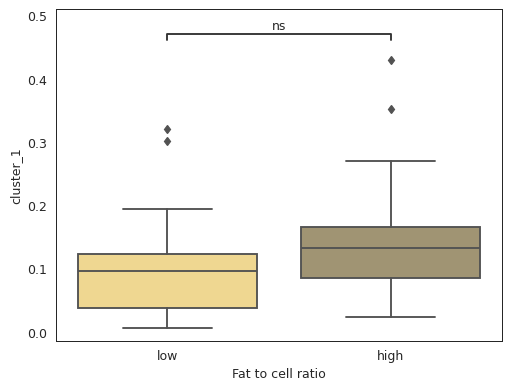

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:2.657e-01 U_stat=7.900e+01


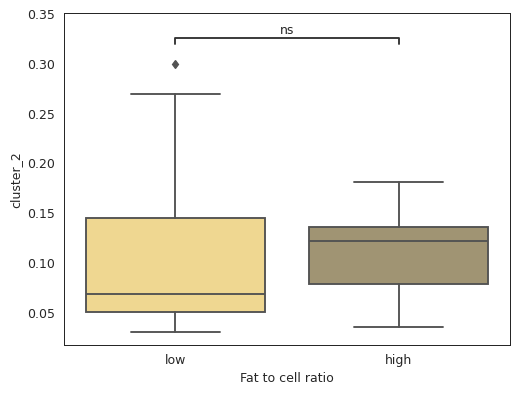

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:9.131e-01 U_stat=1.080e+02


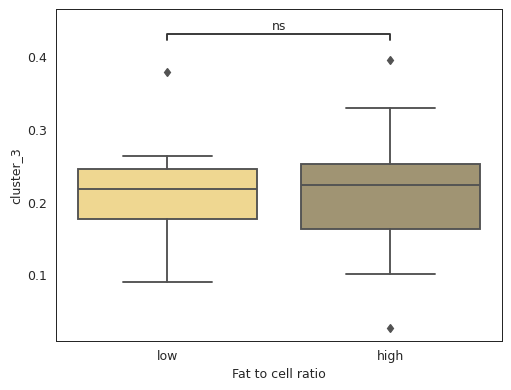

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:2.849e-01 U_stat=8.000e+01


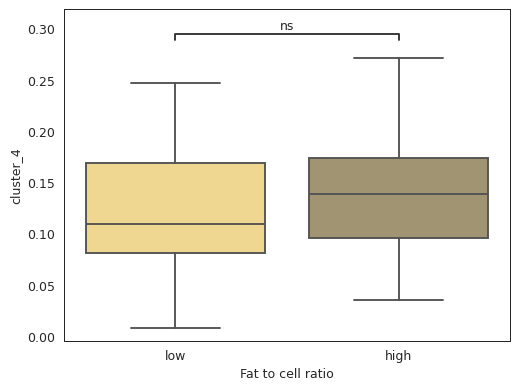

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:9.478e-01 U_stat=1.070e+02


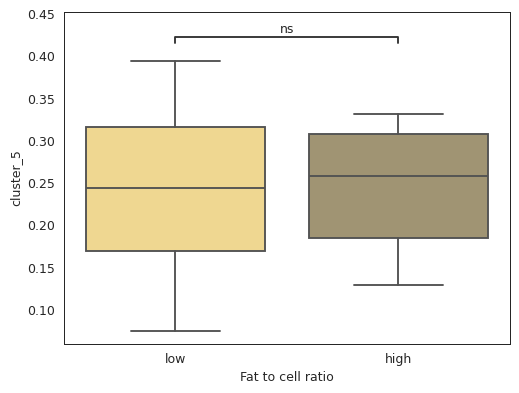

In [96]:
for i in range(0, 6):
    plt.figure()
    ax = sns.boxplot(
        data=community_with_fat,
        x="fat_to_cell_ratio",
        y=f"cluster_{i}",
        order=["low", "high"],
        palette=fat_palette,
    )
    pairs = list(combinations(["low", "high"], 2))
    plt.xlabel("Fat to cell ratio")

    annotator = Annotator(
        ax,
        pairs,
        data=community_with_fat,
        x="fat_to_cell_ratio",
        y=f"cluster_{i}",
        order=["low", "high"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

In [98]:
community_with_fat = community_cell_percentages.join(fat_df)

In [99]:
community_cell_fraction_with_fat = community_cell_fraction.join(fat_df)

### Check whether fat-to-cell ratio associated with cell-type fraction

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:7.011e-02 U_stat=1.470e+02


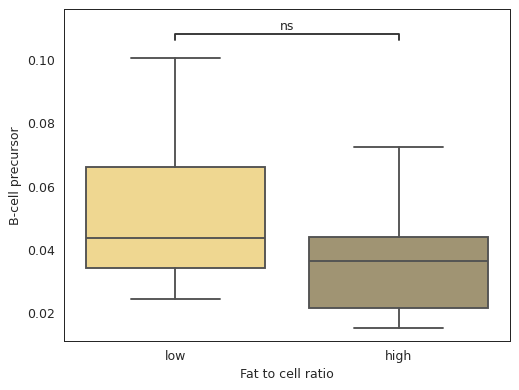

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:6.362e-02 U_stat=6.200e+01


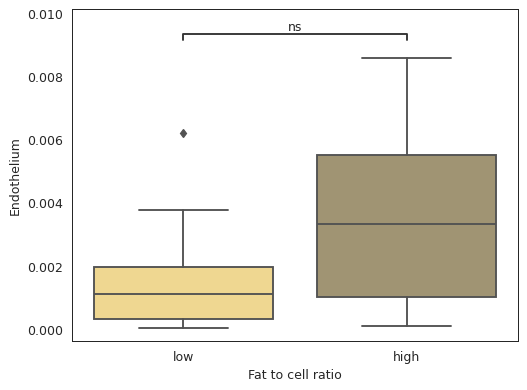

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.979e-01 U_stat=7.500e+01


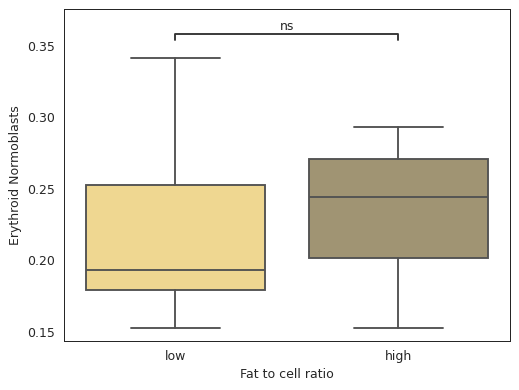

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:2.136e-01 U_stat=7.600e+01


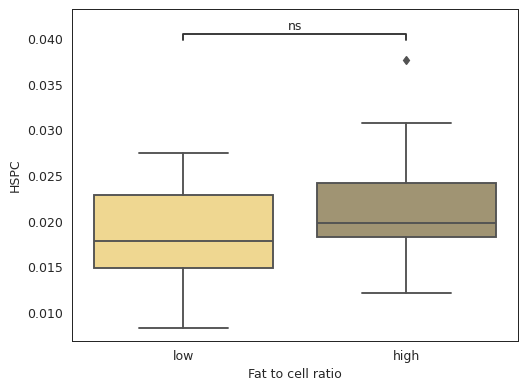

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:5.211e-04 U_stat=1.850e+02


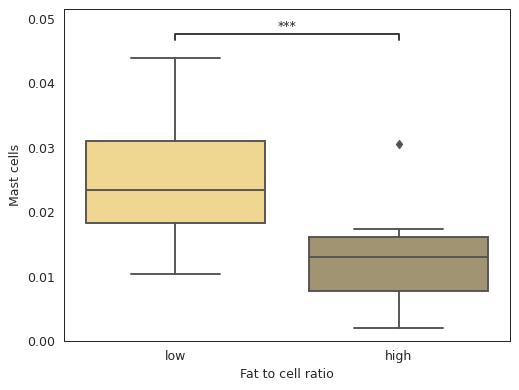

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:7.767e-01 U_stat=1.120e+02


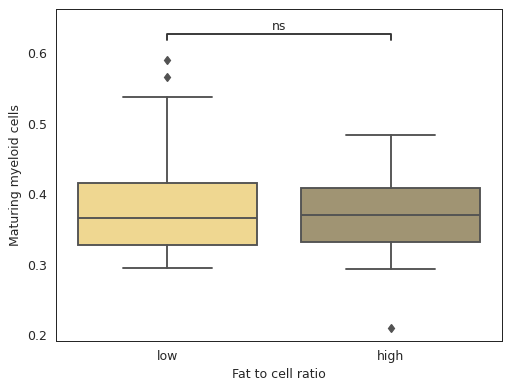

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:8.786e-01 U_stat=1.090e+02


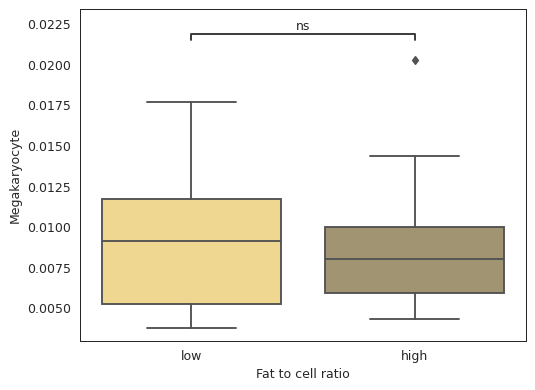

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:3.817e-02 U_stat=1.530e+02


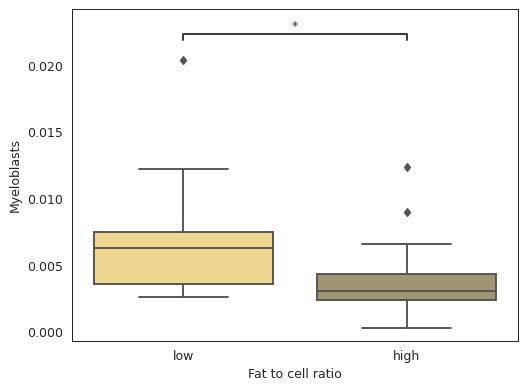

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:7.713e-02 U_stat=6.400e+01


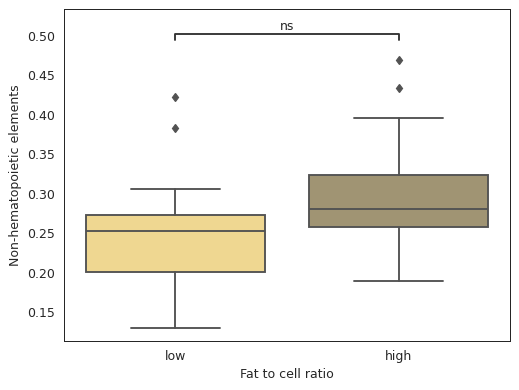

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:9.826e-01 U_stat=1.060e+02


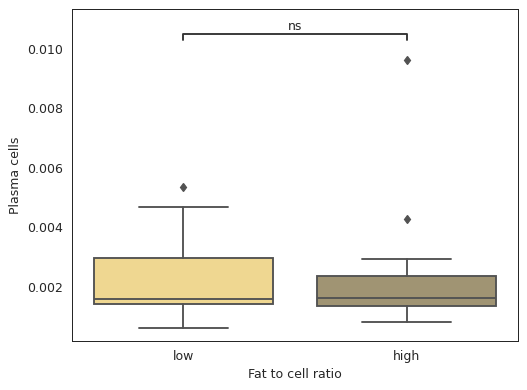

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.367e-02 U_stat=1.620e+02


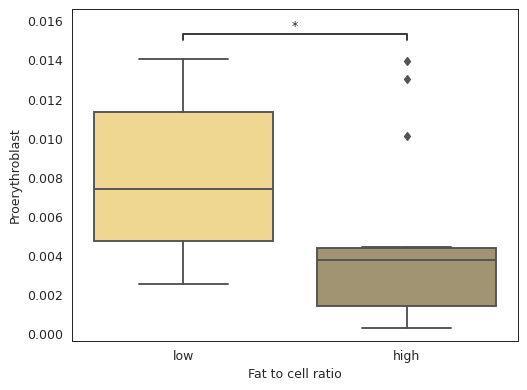

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.148e-03 U_stat=1.800e+02


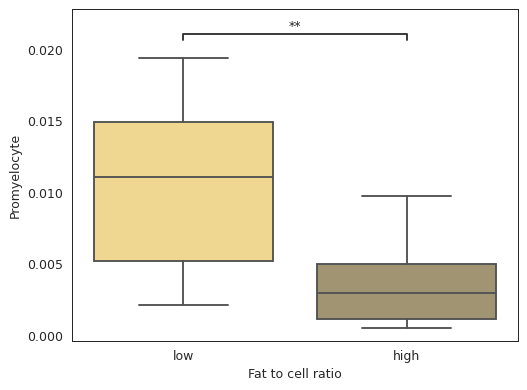

In [100]:
for i in cell_typing.obs["cell_type"].cat.categories:
    plt.figure()
    ax = sns.boxplot(
        data=community_cell_fraction_with_fat,
        x="fat_to_cell_ratio",
        y=i,
        order=["low", "high"],
        palette=fat_palette,
    )
    pairs = list(combinations(["low", "high"], 2))
    plt.xlabel("Fat to cell ratio")

    annotator = Annotator(
        ax,
        pairs,
        data=community_cell_fraction_with_fat,
        x="fat_to_cell_ratio",
        y=i,
        order=["low", "high"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

In [101]:
community_cell_fraction_with_fat_age = community_cell_fraction_with_fat.join(fat_to_age)

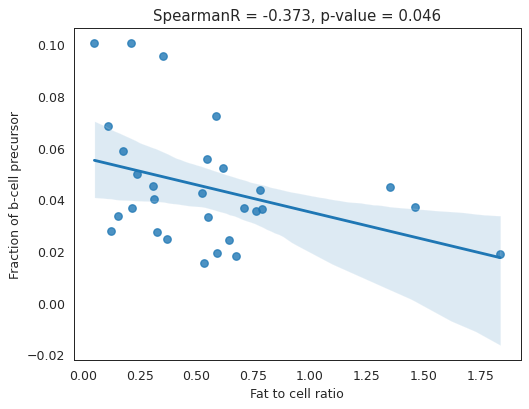

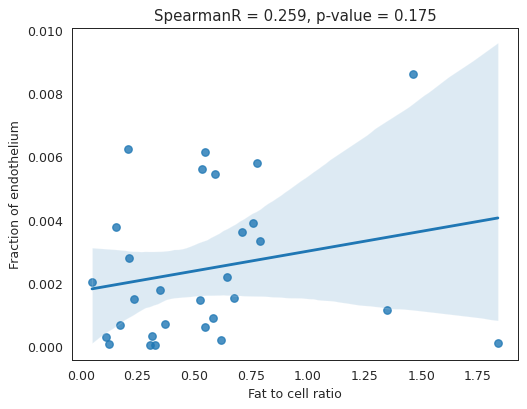

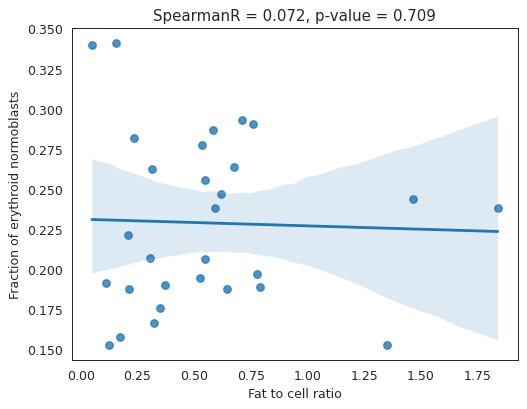

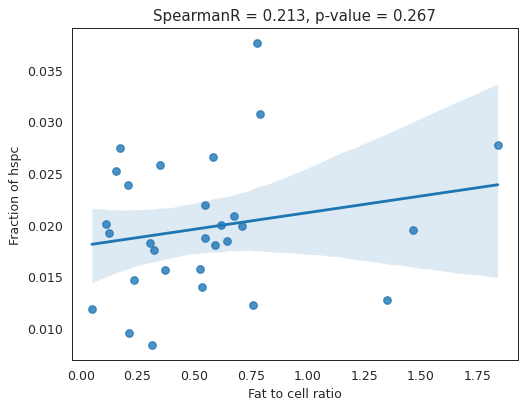

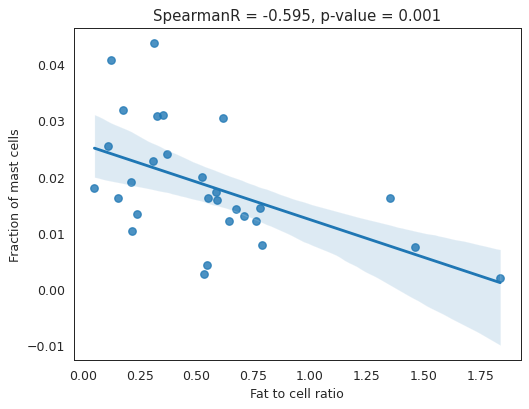

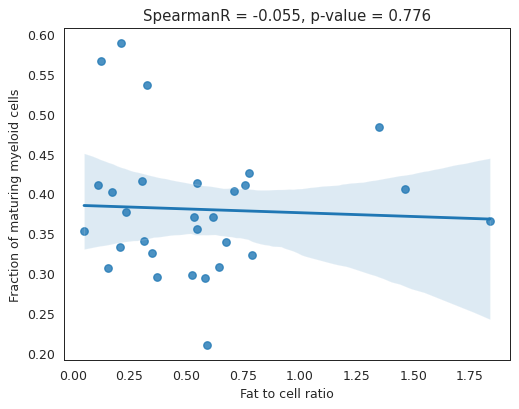

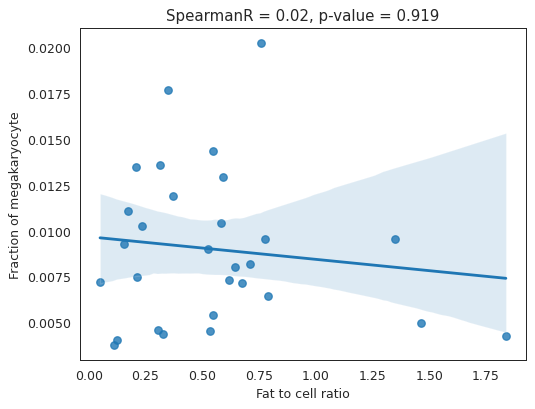

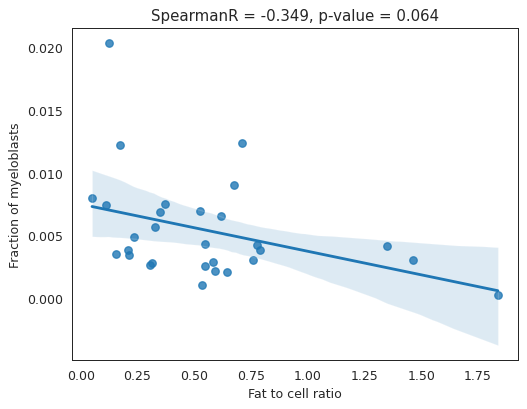

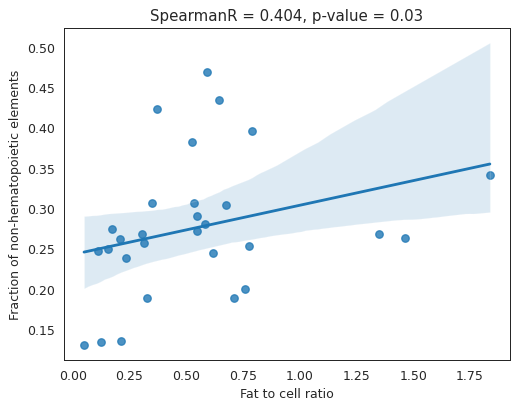

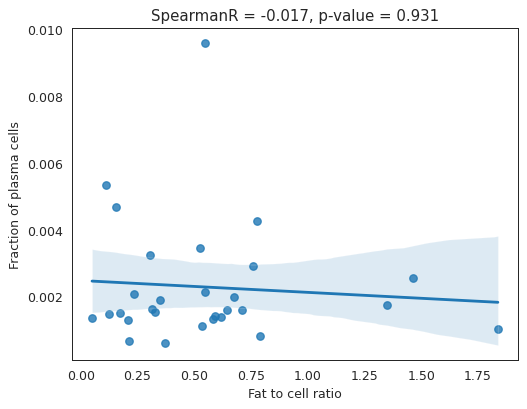

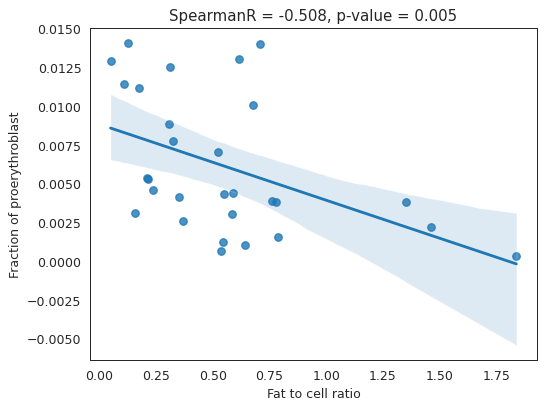

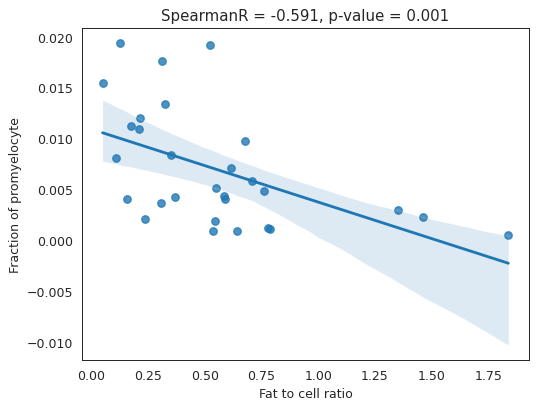

In [102]:
for i in cell_typing.obs["cell_type"].cat.categories:
    plt.figure()

    ax = sns.regplot(
        data=community_cell_fraction_with_fat_age, x="fat_to_cell_amount", y=i
    )

    plt.xlabel("Fat to cell ratio")
    plt.ylabel(f"Fraction of {i.lower()}")
    plt.title(
        f'SpearmanR = {round(stats.spearmanr(community_cell_fraction_with_fat_age[i], community_cell_fraction_with_fat_age["fat_to_cell_amount"])[0], 3)}, p-value = {round(stats.spearmanr(community_cell_fraction_with_fat_age[i], community_cell_fraction_with_fat_age["fat_to_cell_amount"])[1], 3)}'
    )

    plt.show()
    plt.close()

# Platelets

In [106]:
platelets = pd.read_excel("../data/platelets.xlsx")

In [107]:
fat_to_cell_mapping = {
    "WCM1": "high",
    "WCM8": "high",
    "WCM9": "low",
    "WCM10": "high",
    "WCM11": "high",
    "WCM30": "low",
    "WCM31": "low",
    "WCM32": "high",
    "WCM33": "high",
    "WCM34": "low",
    "WCM35": "high",
    "WCM36": "low",
    "WCM38": "high",
    "WCM53": "low",
    "WCM54": "high",
    "WCM55": "high",
    "WCM56": "high",
    "WCM57": "high",
    "WCM59": "low",
    "WCM60": "low",
    "WCM61": "low",
    "WCM62": "low",
    "WCM64": "high",
    "WCM65": "high",
    "WCM66": "low",
    "WCM67": "low",
    "WCM68": "low",
    "WCM69": "high",
    "WCM70": "low",
}

platelets["fat_to_cell_ratio"] = platelets["Case ID"].map(fat_to_cell_mapping)

Hb (g/dL)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:3.592e-01 U_stat=8.350e+01


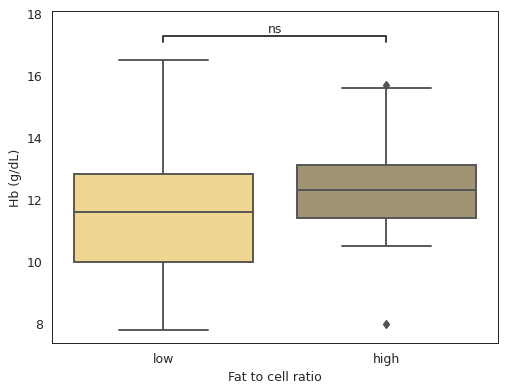

MCV (fL)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:2.745e-02 U_stat=5.400e+01


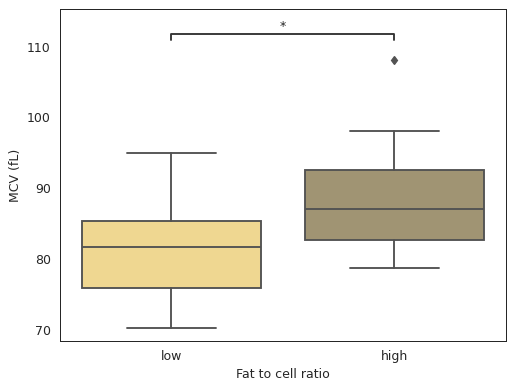

ANC (cells/microliter)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:7.434e-01 U_stat=1.130e+02


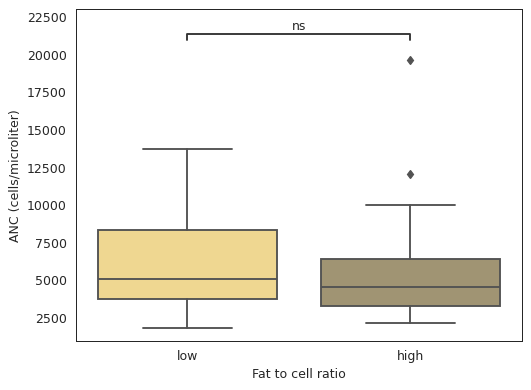

Plts (K cells/microliter)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:4.194e-01 U_stat=1.240e+02


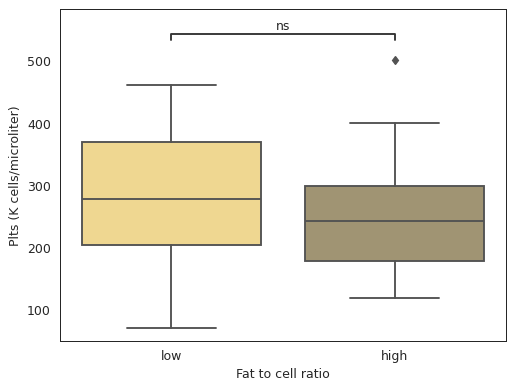

MPV (fL)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:5.262e-01 U_stat=1.200e+02


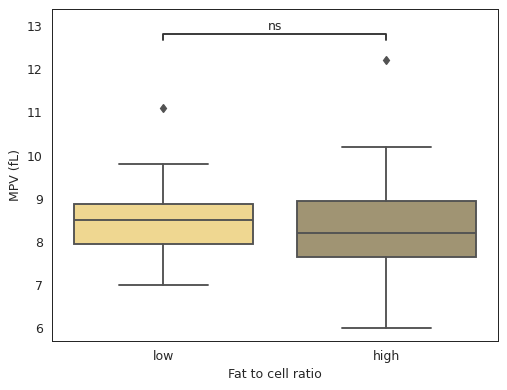

In [108]:
for column in [
    "Hb (g/dL)",
    "MCV (fL)",
    "ANC (cells/microliter)",
    "Plts (K cells/microliter)",
    "MPV (fL)",
]:
    print(column)
    plt.figure()
    ax = sns.boxplot(
        data=platelets,
        x="fat_to_cell_ratio",
        y=column,
        order=["low", "high"],
        palette=fat_palette,
    )
    pairs = list(combinations(["low", "high"], 2))
    plt.ylabel(column)
    plt.xlabel("Fat to cell ratio")

    annotator = Annotator(
        ax,
        pairs,
        data=platelets,
        x="fat_to_cell_ratio",
        y=column,
        order=["low", "high"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

In [109]:
fat_to_cell_age = (
    cell_typing.obs.groupby(["age_group", "case_id"], as_index=True, observed=True)
    .agg({"fat_to_cell_amount": "mean"})
    .reset_index()
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test smaller, P_val:9.615e-03 U_stat=7.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:8.770e-01 U_stat=4.400e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test smaller, P_val:5.888e-02 U_stat=4.400e+01


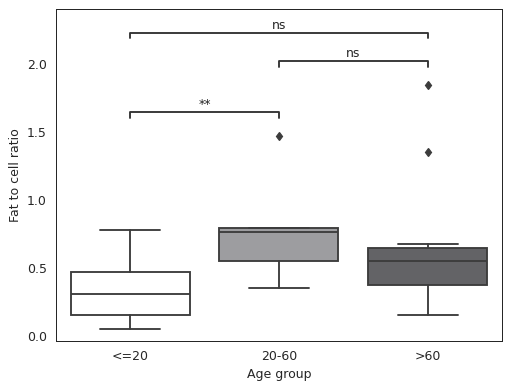

In [110]:
ax = sns.boxplot(
    data=fat_to_cell_age,
    x="age_group",
    y="fat_to_cell_amount",
    order=["<=20", "20-60", ">60"],
    palette=age_group_palette,
)
pairs = list(combinations(["<=20", "20-60", ">60"], 2))
plt.ylabel("Fat to cell ratio")
plt.xlabel("Age group")

annotator = Annotator(
    ax,
    pairs,
    data=fat_to_cell_age,
    x="age_group",
    y="fat_to_cell_amount",
    order=["<=20", "20-60", ">60"],
)
annotator.configure(test="Mann-Whitney-ls", text_format="star", loc="inside")
annotator.apply_and_annotate()

plt.show()
plt.close()

Text(0.5, 1.0, '>60, Mean: 176.212, std: 213.091')

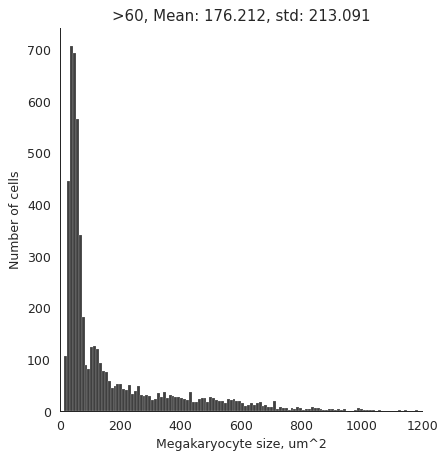

In [122]:
df = cell_typing.obs[
    (cell_typing.obs["cell_type"] == "Megakaryocyte")
    & (cell_typing.obs["age_group"] == ">60")
]["cell_area_um"]

sns.displot(df, color="#000000", bins=200)
plt.xlim(0, 1200)
plt.ylabel("Number of cells")
plt.xlabel("Megakaryocyte size, um^2")

plt.title(f">60, Mean: {df.mean():.3f}, std: {df.std():.3f}")

In [111]:
cell_counts_patient = pd.pivot_table(
    cell_typing.obs,
    index=["case_id", "age_group"],
    columns="cell_type",
    values="cell_index",
    aggfunc="count",
    observed=True,
)

In [112]:
cell_counts_patient_percentage = cell_counts_patient.div(
    cell_counts_patient.sum(axis=1), axis=0
)

In [113]:
cell_counts_patient_percentage = cell_counts_patient_percentage.reset_index()

### Previous plots for all cell types

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.773e-01 U_stat=3.600e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.028e-01 U_stat=4.000e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.293e-02 U_stat=1.010e+02


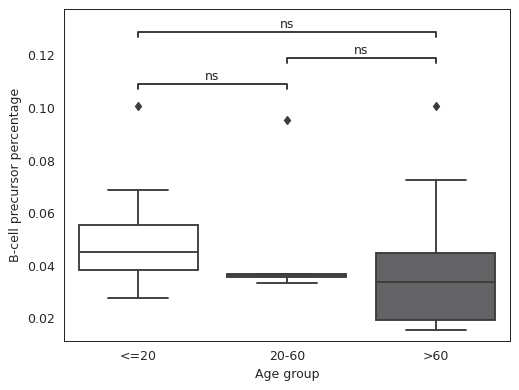

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:6.868e-02 U_stat=1.100e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.028e-01 U_stat=3.700e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.206e-02 U_stat=3.400e+01


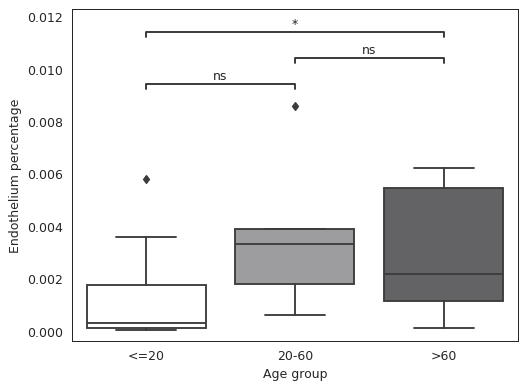

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.130e-01 U_stat=2.900e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.750e-01 U_stat=2.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.620e-01 U_stat=6.800e+01


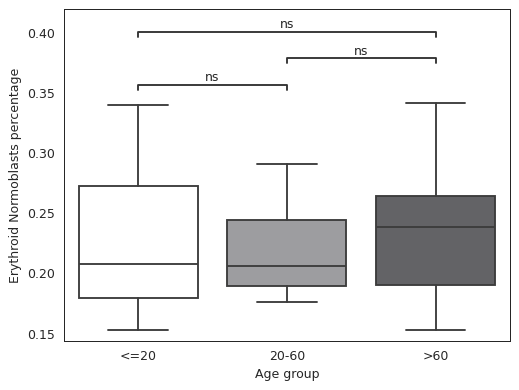

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:6.612e-01 U_stat=2.300e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.663e-01 U_stat=3.900e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:8.620e-01 U_stat=6.800e+01


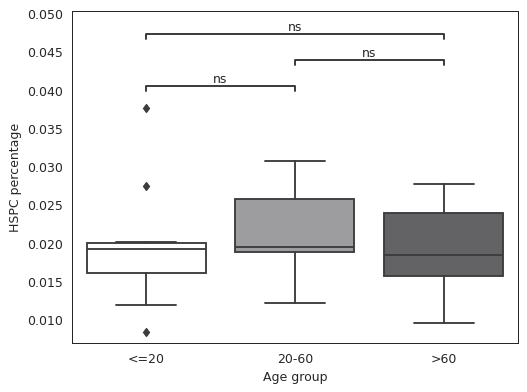

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:6.868e-02 U_stat=4.400e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.200e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.080e-02 U_stat=1.160e+02


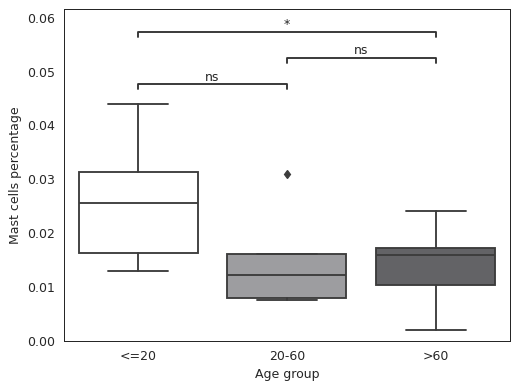

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.773e-01 U_stat=3.600e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.460e-01 U_stat=4.500e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.080e-02 U_stat=1.160e+02


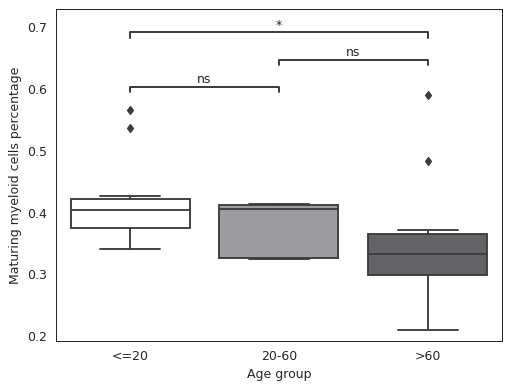

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.096e-01 U_stat=2.100e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.200e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.466e-01 U_stat=5.100e+01


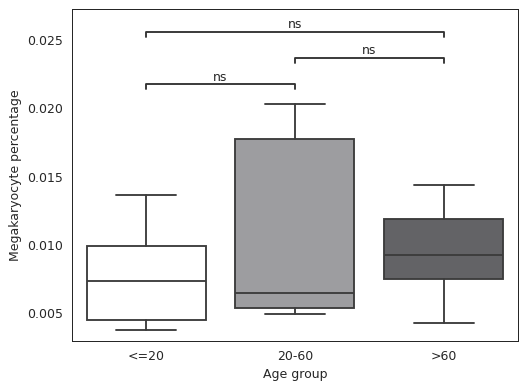

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.804e-01 U_stat=4.000e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:5.028e-01 U_stat=4.000e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.048e-02 U_stat=1.120e+02


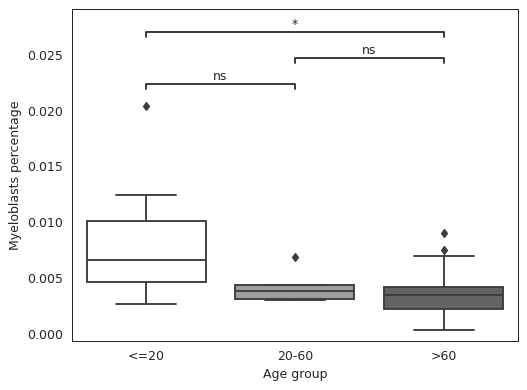

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.800e-02 U_stat=9.000e+00
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:6.331e-01 U_stat=2.700e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.136e-03 U_stat=1.800e+01


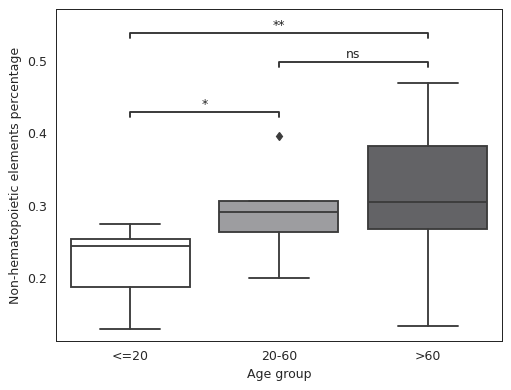

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:7.427e-01 U_stat=2.400e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:4.430e-01 U_stat=4.100e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:2.710e-01 U_stat=9.100e+01


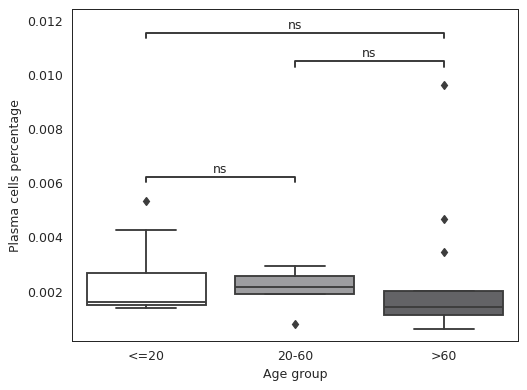

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:3.205e-03 U_stat=5.200e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.200e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:6.302e-04 U_stat=1.310e+02


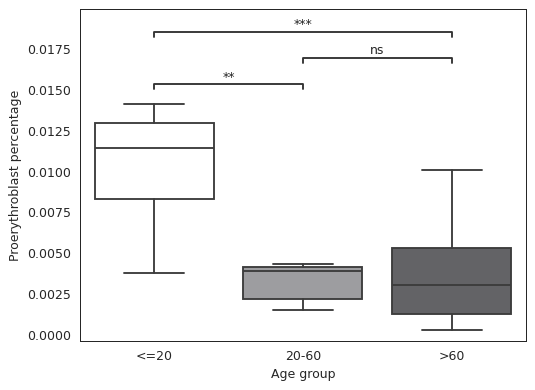

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<=20 vs. 20-60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.451e-01 U_stat=4.100e+01
20-60 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:9.241e-01 U_stat=3.400e+01
<=20 vs. >60: Mann-Whitney-Wilcoxon test two-sided, P_val:1.178e-01 U_stat=9.900e+01


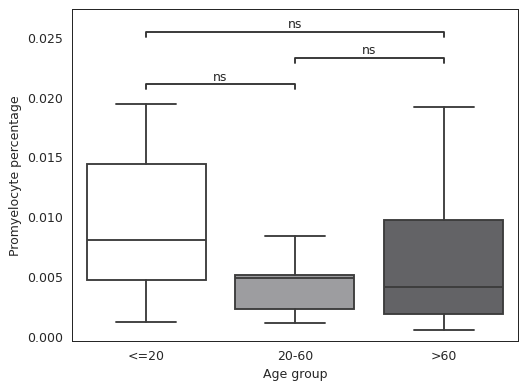

In [114]:
for column in cell_typing.obs["cell_type"].cat.categories:
    plt.figure()

    ax = sns.boxplot(
        data=cell_counts_patient_percentage,
        x="age_group",
        y=column,
        order=["<=20", "20-60", ">60"],
        palette=age_group_palette,
    )
    pairs = list(combinations(["<=20", "20-60", ">60"], 2))
    plt.ylabel(f"{column} percentage")
    plt.xlabel("Age group")

    annotator = Annotator(
        ax,
        pairs,
        data=cell_counts_patient_percentage,
        x="age_group",
        y=column,
        order=["<=20", "20-60", ">60"],
    )
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()

    plt.show()
    plt.close()

In [115]:
cd_columns = cell_typing.obs.filter(like="CD").columns
scaler = MinMaxScaler(clip=False)

mean_intensity_df = cell_typing.obs[cd_columns.tolist() + ["cell_type"]].copy()

for column in cd_columns:
    mean_intensity_df[column] = scaler.fit_transform(
        mean_intensity_df[column].values.reshape(-1, 1)
    )

mean_intensity_df = mean_intensity_df.melt(
    id_vars=["cell_type"], var_name="Marker", value_name="expression"
)

mean_intensity_df["Marker"] = mean_intensity_df["Marker"].map(lambda x: x.split("_")[0])

mean_intensity_df["expression"] = mean_intensity_df["expression"].astype(np.float32)

### Visualize principles of cell typing

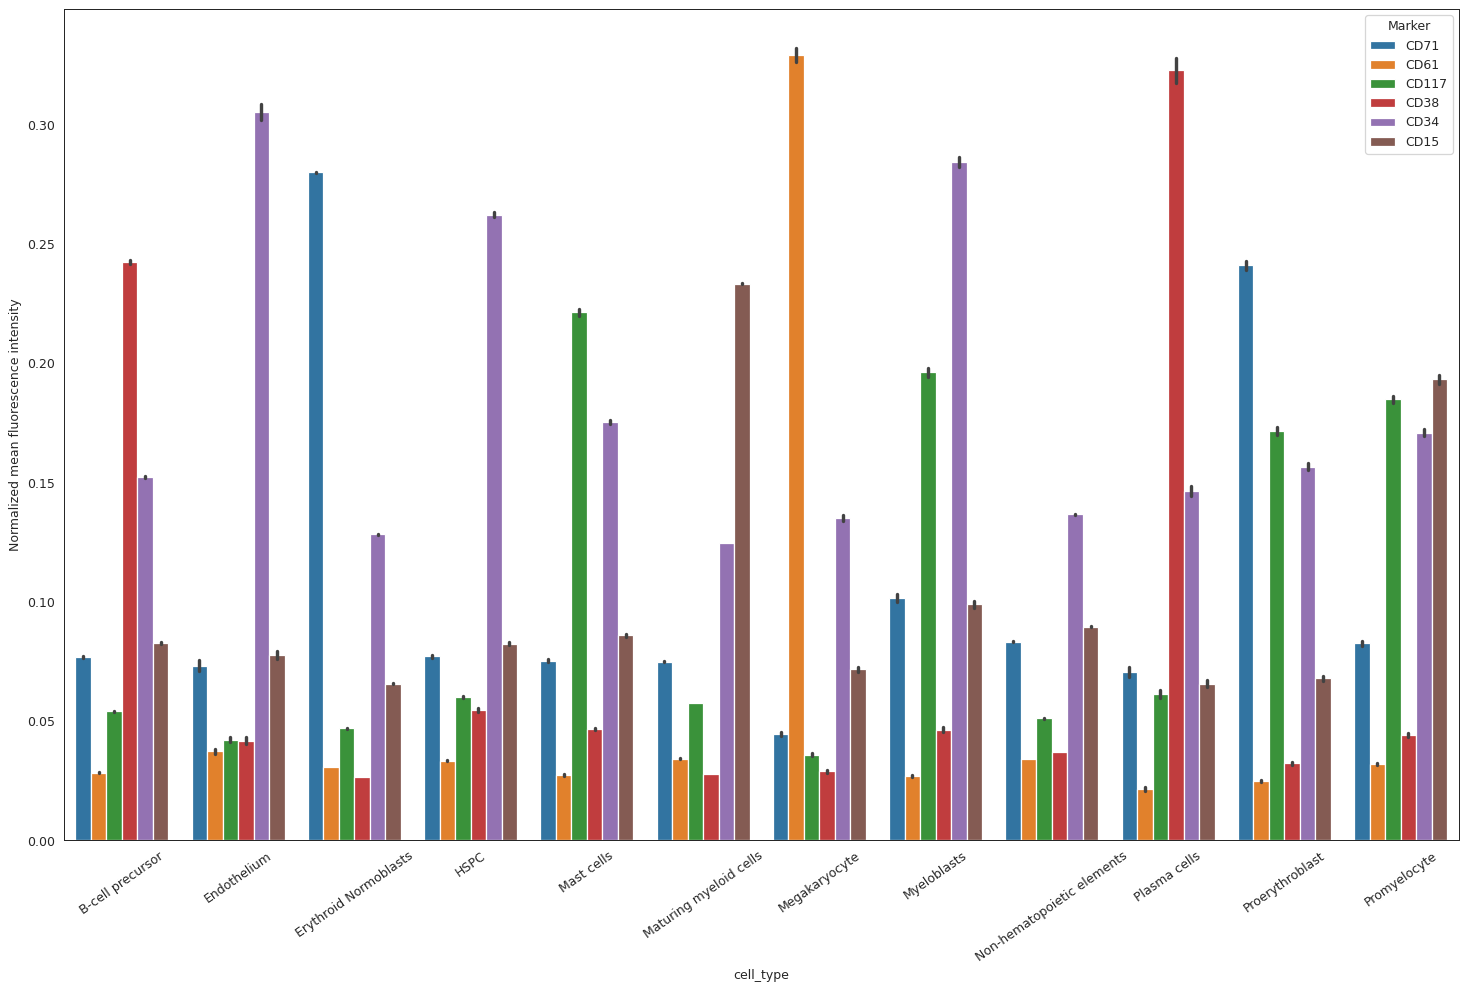

In [116]:
sns.barplot(
    data=mean_intensity_df,
    x="cell_type",
    y="expression",
    hue="Marker",
)
plt.ylabel("Normalized mean fluorescence intensity")
plt.xticks(rotation=35)
plt.gcf().set_size_inches((20, 12))

In [117]:
nucleated_cells = (
    cell_typing.obs.groupby("case_id")
    .agg({"cell_index": "count"})
    .sort_values(by="cell_index")
    .reset_index()
)

### Visualize number of nucleated cells per patient

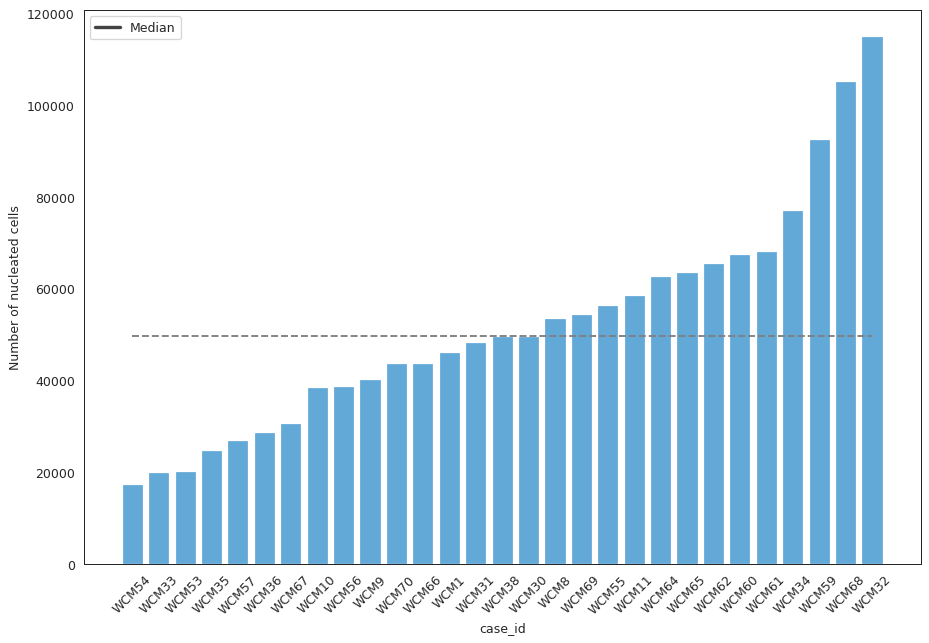

In [118]:
sns.barplot(
    data=nucleated_cells,
    x="case_id",
    y="cell_index",
    order=nucleated_cells["case_id"],
    color="#4EADEA",
)
plt.gcf().set_size_inches((12, 8))
plt.hlines(49669, 0, 28, color="gray", linestyle="dashed")
plt.xticks(rotation=45)
plt.ylabel("Number of nucleated cells")
plt.legend(["Median"])

plt.show()
plt.close()

# Staging, Cytopenia

In [119]:
sc_data = pd.read_excel("../data/cytopenias_staging_sap.xlsx")
sc_data["age_group"] = sc_data["Age at Dx"].map(agify)
sc_data["Cytopenia"] = sc_data["Cytopenia"].apply(str)
sc_data["Staging Proc."] = sc_data["Staging Proc."].apply(str)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:9.451e-01 U_stat=9.700e+01


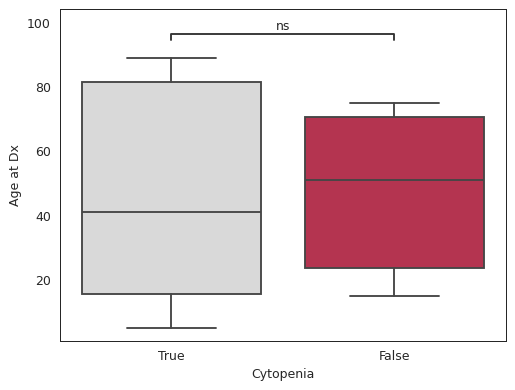

In [120]:
ax = sns.boxplot(
    data=sc_data,
    x="Cytopenia",
    y="Age at Dx",
    order=["True", "False"],
    palette=cytopenia_palette,
)
pairs = list(combinations(["True", "False"], 2))
plt.xlabel("Cytopenia")
plt.ylabel("Age at Dx")

annotator = Annotator(
    ax,
    pairs,
    data=sc_data,
    x="Cytopenia",
    y="Age at Dx",
    order=["True", "False"],
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

plt.show()
plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test two-sided, P_val:2.054e-01 U_stat=4.500e+01


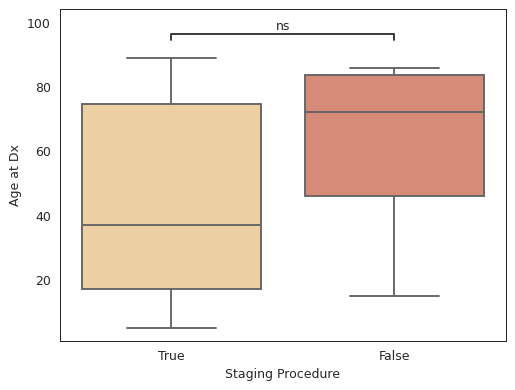

In [121]:
ax = sns.boxplot(
    data=sc_data,
    x="Staging Proc.",
    y="Age at Dx",
    order=["True", "False"],
    palette=staging_palette,
)
pairs = list(combinations(["True", "False"], 2))
plt.ylabel("Age at Dx")
plt.xlabel("Staging Procedure")

annotator = Annotator(
    ax,
    pairs,
    data=sc_data,
    x="Staging Proc.",
    y="Age at Dx",
    order=["True", "False"],
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

plt.show()
plt.close()